# Imports

In [2]:
import pandas as pd
from common import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import preprocessing, metrics
from sklearn.metrics import confusion_matrix
import pyranges as pr
import subprocess

To do:
    
    1. Of windows enriched for 5hmC (TAB and Nanopore):
        - What is the CpG-level agreement? 

Nice to do:
    
    1. Place classes and common functions into modules - Enable single module call at beginning of script.
    2. Break Notebook into composite .py files.

## loading data

In [7]:
dry = False

if dry == True:
    wgbs_bed_path = './test_data/mm39_ENCSR893RHD_modifications_mergeDups_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    oxbs_bed_path = './test_data/CRD018546.gz_val_1_bismark_bt2_pe.deduplicated.bedGraph.gz.bismark.zero.cov_sub.bed'

    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = map(filterDepth, get_nanopore_threeMod(nano_3mod_path))

    nano_2mod_df = filterDepth(get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(get_bismark(oxbs_bed_path, "5mC"))

else:
    wgbs_bed_path = './data/mm39_ENCSR893RHD_merged.bed'
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    oxbs_bed_path = './data/CRR008808_oxBS_remergedRaw.zero.cov_modified.bed'

    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    nano_mc_df, nano_hmc_df = map(filterDepth, get_nanopore_threeMod(nano_3mod_path))

    nano_2mod_df = filterDepth(get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(get_bismark(oxbs_bed_path, "5mC"))

In [16]:
def mergeMethods(bis_df, nano_df):
    bis_df, nano_df = map(lambda df: df.drop(columns=["method", "modification_type"]), [bis_df, nano_df])

    if "strand" in bis_df.columns and "strand" in nano_df.columns:
        wide_merged = pd.merge(bis_df, nano_df, "inner", 
                               ["chromosome", "chromStart", "chromEnd", "strand"], 
                               suffixes=["_Bisulphite", "_Nanopore"])
    else: 
        wide_merged = pd.merge(bis_df, nano_df, "inner", 
                               ["chromosome", "chromStart", "chromEnd"], 
                               suffixes=["_Bisulphite", "_Nanopore"])
    
    long_merged = pd.wide_to_long(wide_merged, stubnames=["readCount", "percentMeth"], i=["chromosome", "chromStart", "chromEnd", "strand"], 
                                  j="method", sep="_", suffix="\D+").reset_index()
    
    wide_merged = wide_merged[["chromosome", "chromStart", "chromEnd", "strand", "readCount_Bisulphite", "percentMeth_Bisulphite", "readCount_Nanopore", "percentMeth_Nanopore"]]
    long_merged = long_merged[["chromosome", "chromStart", "chromEnd", "method", "strand", "readCount", "percentMeth"]]

    return wide_merged.reset_index(drop=True), long_merged

def calcPearson(wide_df):
    x, y = wide_df["percentMeth_Bisulphite"], wide_df["percentMeth_Nanopore"]
    return stats.pearsonr(x, y)

def calcKS(wide_df):
    x, y = wide_df["percentMeth_Bisulphite"], wide_df["percentMeth_Nanopore"]
    return stats.ks_2samp(x, y, method="asymp")

# Checkpointing

In [22]:
class Checkpoint:
    """
    Class to support saving and loading dataframes after intensive data processing steps.  
    """
    def __init__(self, dataframe=None, name=None, path=None):
        self.dataframe = dataframe
        self.name = name
        self.path = path

    def saveCheckpoint(self, name=None, path=None):
        """
        Saves the Checkpoint object as a TSV file in a folder for intermediate data files.
        """
        if self.dataframe.empty:
            raise ValueError("Missing dataframe")
        
        if self.name:
            name = self.name
        else: 
            name = name
            if not name:
                raise ValueError("No name")

        if not path:
            path = self.path
            if not path:
                path = f"./intermediates/{name}.tsv"
                self.path = path

        self.dataframe.to_csv(path, sep="\t", index=False, header=False)
        return 
    
    def getHeaders(self):
        """
        Uses number of columns to estimate column names - based on standards in current analysis.
        """
        colnames = ["chromosome", "chromStart", "chromEnd"]
        first_line = subprocess.check_output(["head", "-n 1", f"{self.path}"]).decode("utf-8").split("\t")

        if len(first_line) == 6: 
            # pyrange
            colnames = (["Chromosome", "Start", "End", "Strand", "percentMeth_Nanopore_5hmC", "percentMeth_Bisulphite_5hmC"])
        elif len(first_line) == 7:
            # long dataframe
            colnames.extend(["method", "strand", "readCount", "percentMeth"])
        elif len(first_line) == 8:
            if self.path.__contains__("three_state"): # adds another condition accounting for files containing all mod states
                colnames.extend(["strand", "percentMeth_Bisulphite_5mC", "percentMeth_Nanopore_5mC", "percentMeth_Bisulphite_5hmC", "percentMeth_Nanopore_5hmC"])
            else: 
                colnames.extend(["strand", "readCount_Bisulphite", "percentMeth_Bisulphite", "readCount_Nanopore", "percentMeth_Nanopore"])
        else:
            raise ValueError("Check file headers.")
        return colnames
    
    def loadCheckpoint(self, colnames=None, path=None):
        """
        Loads the Checkpoint object TSV from either the attribute path or path provided.
        """
        if not path:
            if not self.path:
                raise ValueError("Missing required path string.")
            else: 
                path = self.path
        else:
            self.path = path

        if not colnames:
            colnames = self.getHeaders()

        dataframe = pd.read_csv(path, sep="\t", names=colnames)
        return dataframe

In [10]:
two_mod_wide, two_mod_long = mergeMethods(wgbs_df, nano_2mod_df)
mc_df_wide, mc_df_long  = mergeMethods(oxbs_df, nano_mc_df)
hmc_df_wide, hmc_df_long = mergeMethods(tab_df, nano_hmc_df)

In [11]:
names = ["two_mod_wide", "two_mod_long", "mc_df_wide", "mc_df_long", "hmc_df_wide", "hmc_df_long"]
for idx, df in enumerate([two_mod_wide, two_mod_long, mc_df_wide, mc_df_long, hmc_df_wide, hmc_df_long]):
    name = names[idx]
    cp = Checkpoint(df, name)
    print(f"Now checkpointing {name}.")
    cp.saveCheckpoint()
    print(f"Checkpointed {name}. Saved to {cp.path}")

Now checkpointing two_mod_wide.
Checkpointed two_mod_wide. Saved to ./intermediates/two_mod_wide.tsv
Now checkpointing two_mod_long.
Checkpointed two_mod_long. Saved to ./intermediates/two_mod_long.tsv
Now checkpointing mc_df_wide.
Checkpointed mc_df_wide. Saved to ./intermediates/mc_df_wide.tsv
Now checkpointing mc_df_long.
Checkpointed mc_df_long. Saved to ./intermediates/mc_df_long.tsv
Now checkpointing hmc_df_wide.
Checkpointed hmc_df_wide. Saved to ./intermediates/hmc_df_wide.tsv
Now checkpointing hmc_df_long.
Checkpointed hmc_df_long. Saved to ./intermediates/hmc_df_long.tsv


# Locus level class definitions

### ROCPlot

In [2]:
from sklearn import preprocessing
from sklearn import metrics

class ROCPlot:
    """
    Main object for building a ROC plot from the merged wideform dataframes. 
    """

    def __init__(self, dataframe):
        self.dataframe = dataframe

    def ROCbinariser(self):
        """
        Binarises the bisulphite dataset (mCpG/readCount < 50% = unmodified, mCpG/readCount > 50% = modified).
        """
        binariser = preprocessing.Binarizer(threshold=50)
        self.dataframe["binarised"] = binariser.fit_transform(np.reshape(self.dataframe["percentMeth_Bisulphite"].to_numpy(), (-1, 1)))
        return self.dataframe

    def ROC(self):
        """
        Retrieves the false positive and true positive rates of Nanopore modcalls relative to the binarised bisulphite data.
        """
        binarised_df = self.ROCbinariser()
        fpr, tpr, threshold = metrics.roc_curve(binarised_df["binarised"], binarised_df["percentMeth_Nanopore"])
        return fpr, tpr
    
    def plotROC(self, ax, label):
        """
        Uses the methods above to plot a ROC curve on a given ax. 
        """
        fpr, tpr = self.ROC()
        return ax.plot(fpr, tpr, "-", label=label, lw=2)
    
    def calculateAUC(self):
        """
        For a given ROC curve, calculates the area under that curve (AUC).
        """
        binarised_df = self.ROCbinariser()
        return metrics.roc_auc_score(binarised_df["binarised"], binarised_df["percentMeth_Nanopore"])

## ConfusionMatrix

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

def merge3Mod(): 
    mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()
    hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

    mc_df_wide, hmc_df_wide = map(lambda df: df.drop(columns=["readCount_Bisulphite", "readCount_Nanopore"]), [mc_df_wide, hmc_df_wide])

    merged_df = pd.merge(mc_df_wide, hmc_df_wide, "inner", ["chromosome", "chromStart", "chromEnd", "strand"], suffixes=["_5mC", "_5hmC"])
    return merged_df
    
def defineTruthset():
    truth_list = np.select(
        [Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint()["percentMeth_Bisulphite_5hmC"].gt(50), 
         Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint()["percentMeth_Bisulphite_5mC"].gt(50)],
         ["5hmC", "5mC"], default="C")
    return truth_list

def definePredictions():
    prediction_list = np.select(
        [Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint()["percentMeth_Nanopore_5hmC"].gt(50), 
         Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint()["percentMeth_Nanopore_5mC"].gt(50)],
         ["5hmC", "5mC"], default="C")
    return prediction_list
    
def binBenchmark(wide_df):
    wide_df["bin"] = pd.cut(wide_df["percentMeth_Bisulphite"], 51, labels=np.arange(0, 102, 2))
    return wide_df

def calcChiSquare(wide_df):
    x = pd.cut(wide_df["percentMeth_Bisulphite"], 21, labels=np.arange(0, 105, 5)).value_counts()
    y = pd.cut(wide_df["percentMeth_Nanopore"], 21, labels=np.arange(0, 105, 5)).value_counts()
    return stats.chisquare(x, y)

In [29]:
Checkpoint(merge3Mod()).saveCheckpoint(name="three_state_comparison") 

In [40]:
hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()
mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()

# Stat comparison

## Figure 2.

NameError: name 'binBenchmark' is not defined

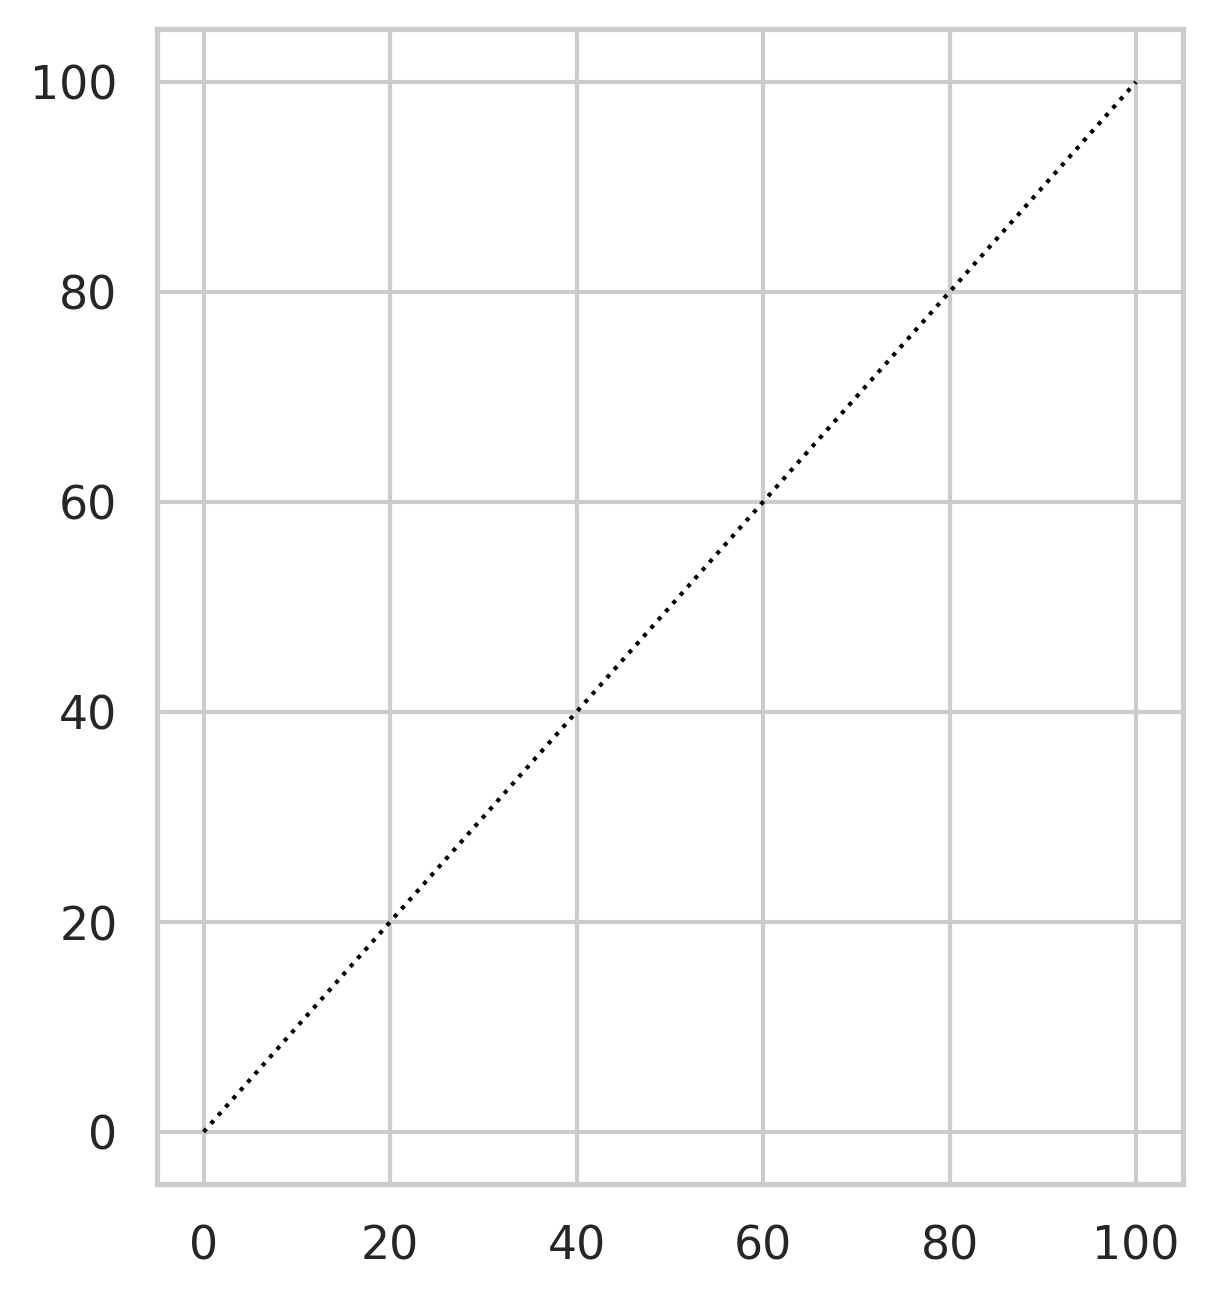

In [17]:
sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")

fig2 = plt.figure(dpi=300, figsize=(15, 5)) 
gs2 = GridSpec(1, 3, fig2)

ax121 = fig2.add_subplot(gs2[0, 0])
ax121.plot(np.arange(0, 105, 5), np.arange(0, 105, 5), linestyle=":", lw=1, color="black")
sns.lineplot(binBenchmark(two_mod_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 75), err_style="band", label="Two-state model", linewidth=2, ax=ax121)
sns.lineplot(binBenchmark(mc_df_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 75), err_style="band", label="Three-state 5mC", linewidth=2, ax=ax121)
sns.lineplot(binBenchmark(hmc_df_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 75), err_style="band", label="Three-state 5hmC", linewidth=2, ax=ax121)
ax121.legend()
sns.move_legend(ax121, "upper left")
ax121.set_ylim((0, 100))
ax121.set_xlim((0, 100))
ax121.set_xlabel("Bisulphite percent modification (%)")
ax121.set_ylabel("Nanopore percent modification (%)")
ax121.set_title("A", loc="left")

ax24 = fig2.add_subplot(gs2[0, 1])
ax24.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), "black", linestyle=":")

ROCPlot(two_mod_wide).plotROC(ax24, "Two-state model")
ROCPlot(mc_df_wide).plotROC(ax24, "Three-state 5mC")
ROCPlot(hmc_df_wide).plotROC(ax24, "Three-state 5hmC")

ax24.set_xlabel("False positive rate")
ax24.set_ylabel("True positive rate")
ax24.legend()
sns.move_legend(ax24, "lower right")
ax24.set_title("B", loc="left")

ax25 = fig2.add_subplot(gs2[0, 2])
ConfusionMatrixDisplay.from_predictions(defineTruthset(), definePredictions(), normalize="true", cmap="Blues", ax=ax25)
ax25.set_title("C", loc="left")

fig2.tight_layout()

# Macro-scale 5hmC analysis

These figures compare 5hmC calling at the level of larger elements, including whole genes and 1kb windows. The focus of these images is on 5hmC - given that this is the modified base with lower apparent classification agreement (see above)

In [5]:
Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint(
        colnames=["chromosome", "chromStart", "chromEnd", "strand", 
                  "percentMeth_Bisulphite_5mC", "percentMeth_Nanopore_5mC", 
                  "percentMeth_Bisulphite_5hmC", "percentMeth_Nanopore_5hmC"])

,chromosome,chromStart,chromEnd,strand,percentMeth_Bisulphite_5mC,percentMeth_Nanopore_5mC,percentMeth_Bisulphite_5hmC,percentMeth_Nanopore_5hmC
0,chr1,3050195,3050196,-,81.2500,76.00,0.000000,0.00
1,chr1,3051030,3051031,+,23.0769,61.11,0.000000,0.00
2,chr1,3058467,3058468,-,64.7059,100.00,0.000000,0.00
3,chr1,3059004,3059005,-,68.7500,56.00,0.000000,0.00
4,chr1,3073014,3073015,+,90.0000,84.62,14.285714,12.50
...,...,...,...,...,...,...,...,...
6396946,chrX_GL456233v2_random,543780,543781,-,41.6667,50.00,0.000000,0.00
6396947,chrX_GL456233v2_random,546349,546350,-,91.6667,90.00,0.000000,0.00
6396948,chrX_GL456233v2_random,547551,547552,-,21.4286,33.33,0.000000,0.00
6396949,chrX_GL456233v2_random,550106,550107,-,25.0000,28.00,0.000000,0.00


In [6]:
def threeModDFtohmCPyrange():
    """
    Produces a PyRange object using only the 5hmC comparison data. 
    """
    data = Checkpoint(path="./intermediates/three_state_comparison.tsv").loadCheckpoint(
        colnames=["chromosome", "chromStart", "chromEnd", "strand", 
                  "percentMeth_Bisulphite_5mC", "percentMeth_Nanopore_5mC", 
                  "percentMeth_Bisulphite_5hmC", "percentMeth_Nanopore_5hmC"])
    pyrange = pr.from_dict({
        "Chromosome" : data["chromosome"],
        "Start" : data["chromStart"],
        "End" : data["chromEnd"],
        "Strand" : data["strand"],
        "percentMeth_Nanopore_5hmC" : data["percentMeth_Nanopore_5hmC"], 
        "percentMeth_Bisulphite_5hmC" : data["percentMeth_Bisulphite_5hmC"]
        }
        )
    return pyrange
    
three_mod_pr = threeModDFtohmCPyrange()
Checkpoint(dataframe=three_mod_pr.as_df(), name="three_mod_pyrange").saveCheckpoint()

In [8]:
# retired - must move
def singleFeatureName(path):
    
    first_line = checkFirstLine(path)
    
    if len(first_line.split("\t")) == 5:
        names=["Chromosome", "Start", "End", "Name", "Strand"]
    elif len(first_line.split("\t")) == 6:
        names=["Chromosome", "Start", "End", "Name", "Score", "Strand"]
    else:
        raise ValueError("Please check number of columns in file. Must equal 5 or 6.")
    
    bed_file = pd.read_csv(path, sep="\t", names=names)
    bed_file["Name"] = bed_file["Name"].apply(lambda names: names.split(",").pop(0))

    file_name = "/".join(path.split("/")[0:4]) + "/name_adjusted/" + path.split("/")[4]
    
    bed_file.to_csv(file_name, "\t", header=False, index_label=None, index=False)
    return 
    
directory_list = subprocess.check_output(["ls", "./feature_references/revised/gene_features/"]).decode("utf-8").split("\n")[0:8]

for name in directory_list:
    name = "./feature_references/revised/gene_features/" + name
    try:
        singleFeatureName(name)
    except ValueError:
        continue

NameError: name 'checkFirstLine' is not defined

In [53]:
class refTSV:
    """
    Superclass of tab-separated (incl. bed) files used for feature alignment. 
    """
    def __init__(self, path):
        self.path = path
    
    def checkNumColumns(self):
        """
        Checks and returns the number of columns present in the TSV file.
        """
        first_line = subprocess.check_output(["head", "-n 1", f"{self.path}"]).decode("utf-8")
        num_columns = len(first_line.split("\t"))

        return num_columns
    
    def getColNames(self):
        """
        Uses the number of columns to predict column name labels. 
        """
        names = ["Chromosome", "Start", "End"]
        return names
    
    def getFirstLine(self):
        first_line = subprocess.check_output(["head", "-n 1", f"{self.path}"]).decode("utf-8").split("\t")
        return first_line
    
class featureTSV(refTSV):
    """
    Regularly used file type containing information about genomic features. Columns must contain follow BED 'Chromosome', 'Start', 'End', 'Name' format. 
    """

    def __init__(self, path):
        super().__init__(path)
   
    def getColNames(self):
        """
        Uses the number of columns to predict column name labels. 
        """
        col_length = super().checkNumColumns()
        names =  super().getColNames()
        
        if col_length == 4:
            names.extend(["Name"])
        elif col_length == 5:
            names.extend(["Name", "Strand"])
        elif col_length == 6:
            names.extend(["Name", "Score", "Strand"])
        else:
            raise ValueError("Please check number of columns in file. Must equal 4, 5, or 6.")
        return names
    
    def retrieveFeatureType(self):
        """
        Uses the file extension to determine the type of feature. File must be saved in a './1_2_3_feature-type_4.bed' fashion. 
        """
        filename = self.path.split("/").pop(-1)
        feature_type = filename.split("_").pop(3)

        return feature_type
    
    def toDF(self):
        """
        Shows the feature file as a pandas DataFrame.
        """
        df = pd.read_csv(self.path, sep="\t", names=self.getColNames())
        df["feature_type"] = self.retrieveFeatureType()
        
        return df

class cgiTSV(refTSV):
    """
    Subclass of reference tab-separated variable file containing information about CpG island positions. file
    """
    def __init__(self, path):
        self.path = path

    def retrieveFeatureType(self):
        first_line = super().getFirstLine()
        
        return first_line[-1].strip("\n")
    
    def getColNames(self):
        """
        Uses the number of columns to predict column name labels. 
        """
        col_length = super().checkNumColumns()
        names =  super().getColNames()
        first_line = super().getFirstLine()

        if first_line[3].__contains__("CpG"):
            names.extend(["NCpGs", "feature_type"])
        else:
            names.extend(["Name", "feature_type"])
        
        return names
    
    def toDF(self):
        """
        Shows the feature file as a pandas DataFrame.
        """
        df = pd.read_csv(self.path, sep="\t", names=self.getColNames())
        
        return df
    
def makeFeatureRefPyRange():
    gene_feature_list = subprocess.check_output(["ls", "./feature_references/revised/gene_features/name_adjusted/"]).decode("utf-8").split("\n") 
    gene_feature_list.pop(-1)

    df_list = []
    for file in gene_feature_list:
        path = "./feature_references/revised/gene_features/name_adjusted/" + file
        feature_tsv = featureTSV(path)
        feature_df = feature_tsv.toDF()
        df_list.append(feature_df)

    feature_reference_df = pd.concat(df_list).drop(columns=["Score"])
    return pr.PyRanges(feature_reference_df)

def makeCGIrefPyRange():
    cgi_feature_list = subprocess.check_output(["ls", "./feature_references/revised/cgi/named/"]).decode("utf-8").split("\n") 
    cgi_feature_list.pop(-1)

    cgi_df_list = []
    for file in cgi_feature_list:
        path = "./feature_references/revised/cgi/named/" + file
        cgi_tsv = cgiTSV(path)
        cgi_df = cgi_tsv.toDF()
        cgi_df_list.append(cgi_df)

    cgi_reference_df = pd.concat(cgi_df_list)
    return pr.PyRanges(cgi_reference_df)

## Grouped CpG Class definitions

In [4]:
import subprocess
import pandas as pd

pyrange_data = Checkpoint(path='./intermediates/three_mod_pyrange.tsv').loadCheckpoint()

### CpG intersects

In [5]:
import pyranges as pr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

class CpGIntersects(pr.PyRanges):
    """
    Main class for feature/gene level comparison. Inherits from PyRange. 
    """
    def __init__(self, df):
        super().__init__(df, df)

    def __intersectGenes(self):
        """
        Intersects CpGs with genes. Based on gene start/end coordinates in the GENCODE Basic reference build. 
        """
        gene_ref_path = './feature_references/revised/GENCODE_Basic_mm39_Genes_merged.bed'
        gene_ref = pd.read_csv(gene_ref_path, 
                               sep="\t", 
                               names=["Chromosome", "Start", "End", "Name", "Strand"])
        gene_ref_pr = pr.PyRanges(gene_ref).unstrand()
        df_with_genes = self.join(gene_ref_pr, slack=0).as_df()
        df_with_genes["feature_type"] = "Gene"
        return  df_with_genes
    
    def __intersectFeatures(self):
        """
        Intersects CpGs with genomic features. Output is a dataframe-type object. 
        """
        feature_ref = makeFeatureRefPyRange().unstrand()
        df_with_features = self.join(feature_ref, slack=0).as_df()
        categories = ["Intergenic", "Promoter", "5UTR", "TSS", "Intron", "Exon", "3UTR", "TTS"]
        df_with_features["feature_type"] = pd.Categorical(df_with_features["feature_type"], categories)

        return  df_with_features
    
    def __intersectCpGIslands(self):
        """
        Intersects CpGs with CpG islands. Islands are broken into island feature (i.e.: shelf, shore). 
        """
        cgi_ref = makeCGIrefPyRange().unstrand()
        df_with_cgis = self.join(cgi_ref, slack=0).as_df()
        categories = ["Open sea", "Upstream shelf", "Upstream shore", "CGI", "Downstream shore", "Downstream shelf"]
        df_with_cgis["feature_type"] = pd.Categorical(df_with_cgis["feature_type"], categories)

        return  df_with_cgis
    
    def groupByGenomicWindow(self, window_size):
        """
        Groups CpGs based according to 1kb windows ("tiles"), using the average (mean) hydroxymethlyation of CpGs within those windows. Output is distinct from the grouping function below as the chromosomal coordinates are actually what defines each cluster. 
        """
        tiled_pr = self.tile(window_size, strand=False).cluster(slack=-1, strand=False)
        cluster_pr = tiled_pr.merge(slack=-1, count=True, strand=False)
        cluster_pr = cluster_pr.insert(
            tiled_pr.apply(
            f=lambda df: df.groupby("Cluster")[["percentMeth_Nanopore_5hmC", "percentMeth_Bisulphite_5hmC"]].mean(), 
            as_pyranges=False, strand=False
            )
            )
        cluster_df = cluster_pr.as_df()
        return cluster_df.rename(columns={
            "percentMeth_Bisulphite_5hmC" : "percentMeth_Bisulphite",
            "percentMeth_Nanopore_5hmC" : "percentMeth_Nanopore",
            "Count": "CpG_count"}
            )
    
    def group(self, intersect_with):
        """
        Groups CpGs based on intersects.
        """
        if intersect_with == "genes" or intersect_with == "Genes":
            intersect_df = self.__intersectGenes()
        elif intersect_with == "features" or intersect_with == "Features":
            intersect_df = self.__intersectFeatures()
        elif intersect_with == "CGI" or intersect_with == "islands":
            intersect_df = self.__intersectCpGIslands()
        else: 
            raise ValueError("Please input appropriate element to intersect with.")
        
        groupby_df = intersect_df.groupby(["Name", "feature_type", "Start_b", "End_b"], 
                                          observed=True).agg(
            {"percentMeth_Nanopore_5hmC" : "mean",
             "percentMeth_Bisulphite_5hmC" : "mean",
             "Start" : "count"}
             ).reset_index()
        groupby_df.rename(columns={"Start" : "CpG_count",
                                   "Start_b" : "group_start",
                                   "End_b" : "group_end",
                                   "percentMeth_Bisulphite_5hmC" : "percentMeth_Bisulphite",
                                   "percentMeth_Nanopore_5hmC" : "percentMeth_Nanopore"}, 
                                   inplace=True)

        return  groupby_df
       
    def calculateMethodMean(self):
        df = self.as_df()

        mean_dict = {"bisulphite_mean" : df["percentMeth_Bisulphite_5hmC"].mean(),
                     "nanopore_mean" : df["percentMeth_Nanopore_5hmC"].mean()}

        return mean_dict


### GroupedDF

In [6]:
class groupedDF:
    """
    Dataframe-type objects where CpG positions are grouped. Child classes contain additional functionality. Contains interface for relevant Seaborn plotting functions.  
    """
    def __init__(self, df, cpg_threshold):
        self.df = df
        self.cpg_threshold = cpg_threshold
      
    def dfWithLogCols(self):
        """
        Adds columns indicating the log2scale enrichment/depletion of grouped CpG sites relative to the mean of each method. 
        """
        filtered_df = self.df.copy()
        filtered_df = filtered_df.loc[filtered_df["CpG_count"].ge(self.cpg_threshold)] # filters out groups with fewer than X CpGs present in either dataset. 

        with np.errstate(divide="ignore"):
            filtered_df["Log2FromMean_Bisulphite"] = np.log2(
                np.divide(
                filtered_df["percentMeth_Bisulphite"],
                filtered_df["percentMeth_Bisulphite"].mean()
                )
                )

            filtered_df["Log2FromMean_Nanopore"] = np.log2(
                np.divide(
                filtered_df["percentMeth_Nanopore"],
                filtered_df["percentMeth_Nanopore"].mean()
                )
                )
        
        filtered_df = filtered_df.replace(-np.inf, np.nan).dropna()

        return filtered_df
    
    def methodComparison(self):
        """
        Adds "Average" and "Difference" to the dataframe, displaying the average level of enrichment and difference between method enrichment levels respectively.
        """
        df = self.dfWithLogCols()

        df["Average"] = df[["Log2FromMean_Bisulphite", "Log2FromMean_Nanopore"]].mean(axis=1)
        df["Difference"] = np.subtract(df["Log2FromMean_Bisulphite"], df["Log2FromMean_Nanopore"])
        
        return df
    
    def calcPearson(self):
        df = self.dfWithLogCols()

        return stats.pearsonr(df["Log2FromMean_Bisulphite"],
                              df["Log2FromMean_Nanopore"])
    
    def calcSpearman(self):
        df = self.dfWithLogCols()

        return stats.spearmanr(df["Log2FromMean_Bisulphite"],
                               df["Log2FromMean_Nanopore"])
    
    def calcMannWhitney(self, alternative):
        df = self.dfWithLogCols()

        return stats.mannwhitneyu(df["Log2FromMean_Bisulphite"],
                                  df["Log2FromMean_Nanopore"], 
                                  alternative=alternative)
    
    def makeHist(self, stat, ax=None):
        df = self.dfWithLogCols()

        if not ax:
            fig, ax = plt.subplots()

        hist = sns.histplot(df, x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", cbar=True, cbar_kws={"label" : f"{stat}".capitalize()}, stat=stat, ax=ax)

        return hist

### featureAndGene

In [7]:
class featureAndGene(groupedDF):
    """
    Dataframe-like objects where CpG sites are grouped by gene, genomic feature, or CpG island. 
    """
    def __init__(self, df):
        super().__init__(df)

    def __asLongDf(self):
        """
        Converts the DF from a wide-form to a longer form. 
        """
        df = self.df

        stubs = ["percentMeth"]
        indices = ["Name", "group_start", "group_end"]
        
        return pd.wide_to_long(df, stubs, indices, "method", sep="_", suffix="\D+").reset_index()
    
    def makeLineplot(self, ax=None):
        df = self.__asLongDf()

        if not ax:
            fig, ax = plt.subplots()
        
        lineplot = sns.lineplot(df, x="feature_type", y="percentMeth", hue="method", errorbar=("ci", 50), estimator="median")
        return lineplot
    
    def makeBarplot(self, ax=None):
        df = self.__asLongDf()

        if not ax:
            fig, ax = plt.subplots()
        
        barplot = sns.barplot(df, x="feature_type", y="percentMeth", hue="method", errorbar=("pi", 50), estimator="median", capsize=0.1, errwidth=1, ax=ax)
        return barplot

### tiledGroup

In [8]:
class tiledGroup(groupedDF):
    """
    Dataframe-like objects where CpG sites are grouped by genomic window or tile. 
    """
    def __init__(self, df, cpg_threshold):
        super().__init__(df, cpg_threshold)

    def positiveControlGroupDF(self, number_target_tiles):
        """
        Returns the positive control group - entries enriched in both methods.
        """
        df = super().methodComparison()
        df = df.nlargest(50, "Average")
        df = df.nsmallest(number_target_tiles, "Difference")
        return df
    
    def NegativeControlGroupDF(self, number_target_tiles):
        """
        Returns the negative control group - entries not enriched in either method.
        """
        df = self.methodComparison()
        df = df.nsmallest(50, "Average")
        df = df.nsmallest(number_target_tiles, "Difference")
        return df

    def NanoporePositiveGroupDF(self, number_target_tiles):
        """
        Returns the Nanopore positive test group - entries enriched only in Nanopore.
        """
        df = self.methodComparison()
        df = df.loc[df["Log2FromMean_Bisulphite"] <= 0]
        df = df.nlargest(number_target_tiles, "Log2FromMean_Nanopore")
        return df
    
    def TabPositiveGroupDF(self, number_target_tiles):
        """
        Returns the TAB positive test group - entries enriched only in TAB.
        """
        df = self.methodComparison()
        df = df = df.loc[df["Log2FromMean_Nanopore"] <= 0]
        df = df.nlargest(number_target_tiles, "Log2FromMean_Bisulphite")
        return df
    
    def exportTestGroups(self, number_target_tiles):
        wr = pd.ExcelWriter('./outputs/target_300bp.xlsx')

        self.NanoporePositiveGroupDF(number_target_tiles).to_excel(wr, "Nanopore_positive")
        self.TabPositiveGroupDF(number_target_tiles).to_excel(wr, "TAB_positive")
        self.positiveControlGroupDF(number_target_tiles).to_excel(wr, "Positive_ctrl")
        self.NegativeControlGroupDF(number_target_tiles).to_excel(wr, "Negative_ctrl")

        wr.close()
        return

## Output list of possible target genes

In [74]:
import mygene
import openpyxl

def splitENSIDSeries(df):
    df["ENSID"] = df["geneName"].apply(lambda s: s.split(",").pop(0).split(".")[0])
    return df

def getEntrezName(df):
    df = splitENSIDSeries(df)
    mg = mygene.MyGeneInfo()
    query = pd.DataFrame(mg.querymany(df["ENSID"], scopes="ensembl.transcript", fields="symbol"))
    df["EntrezName"] = list(query["symbol"])
    return df[["EntrezName", "Log2FromMean_Bisulphite", "Log2FromMean_Nanopore", "Difference", "Count"]]

writer = pd.ExcelWriter('./outputs/target_genes.xlsx', engine="openpyxl")

df_list = [getEntrezName(geneNegativeControl()), getEntrezName(genePositiveControl()), getEntrezName(geneNanoporePositive()), getEntrezName(geneTabPositive())]

sheet_names = ["negative_control", "positive_control", "nanopore_positive", "tab_positive"]

for i in np.arange(0, 4, 1):
    sheet = sheet_names[i]
    df_list[i].to_excel(writer, sheet)
writer.close()


INFO:biothings.client:querying 1-10...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-10...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-10...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:querying 1-10...
INFO:biothings.client:done.
INFO:biothings.client:Finished.


/tmp/ipykernel_831735/440320194.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax33.set_xticklabels(["Open\nsea", "Upstream\nshelf", "Upstream\nshore",


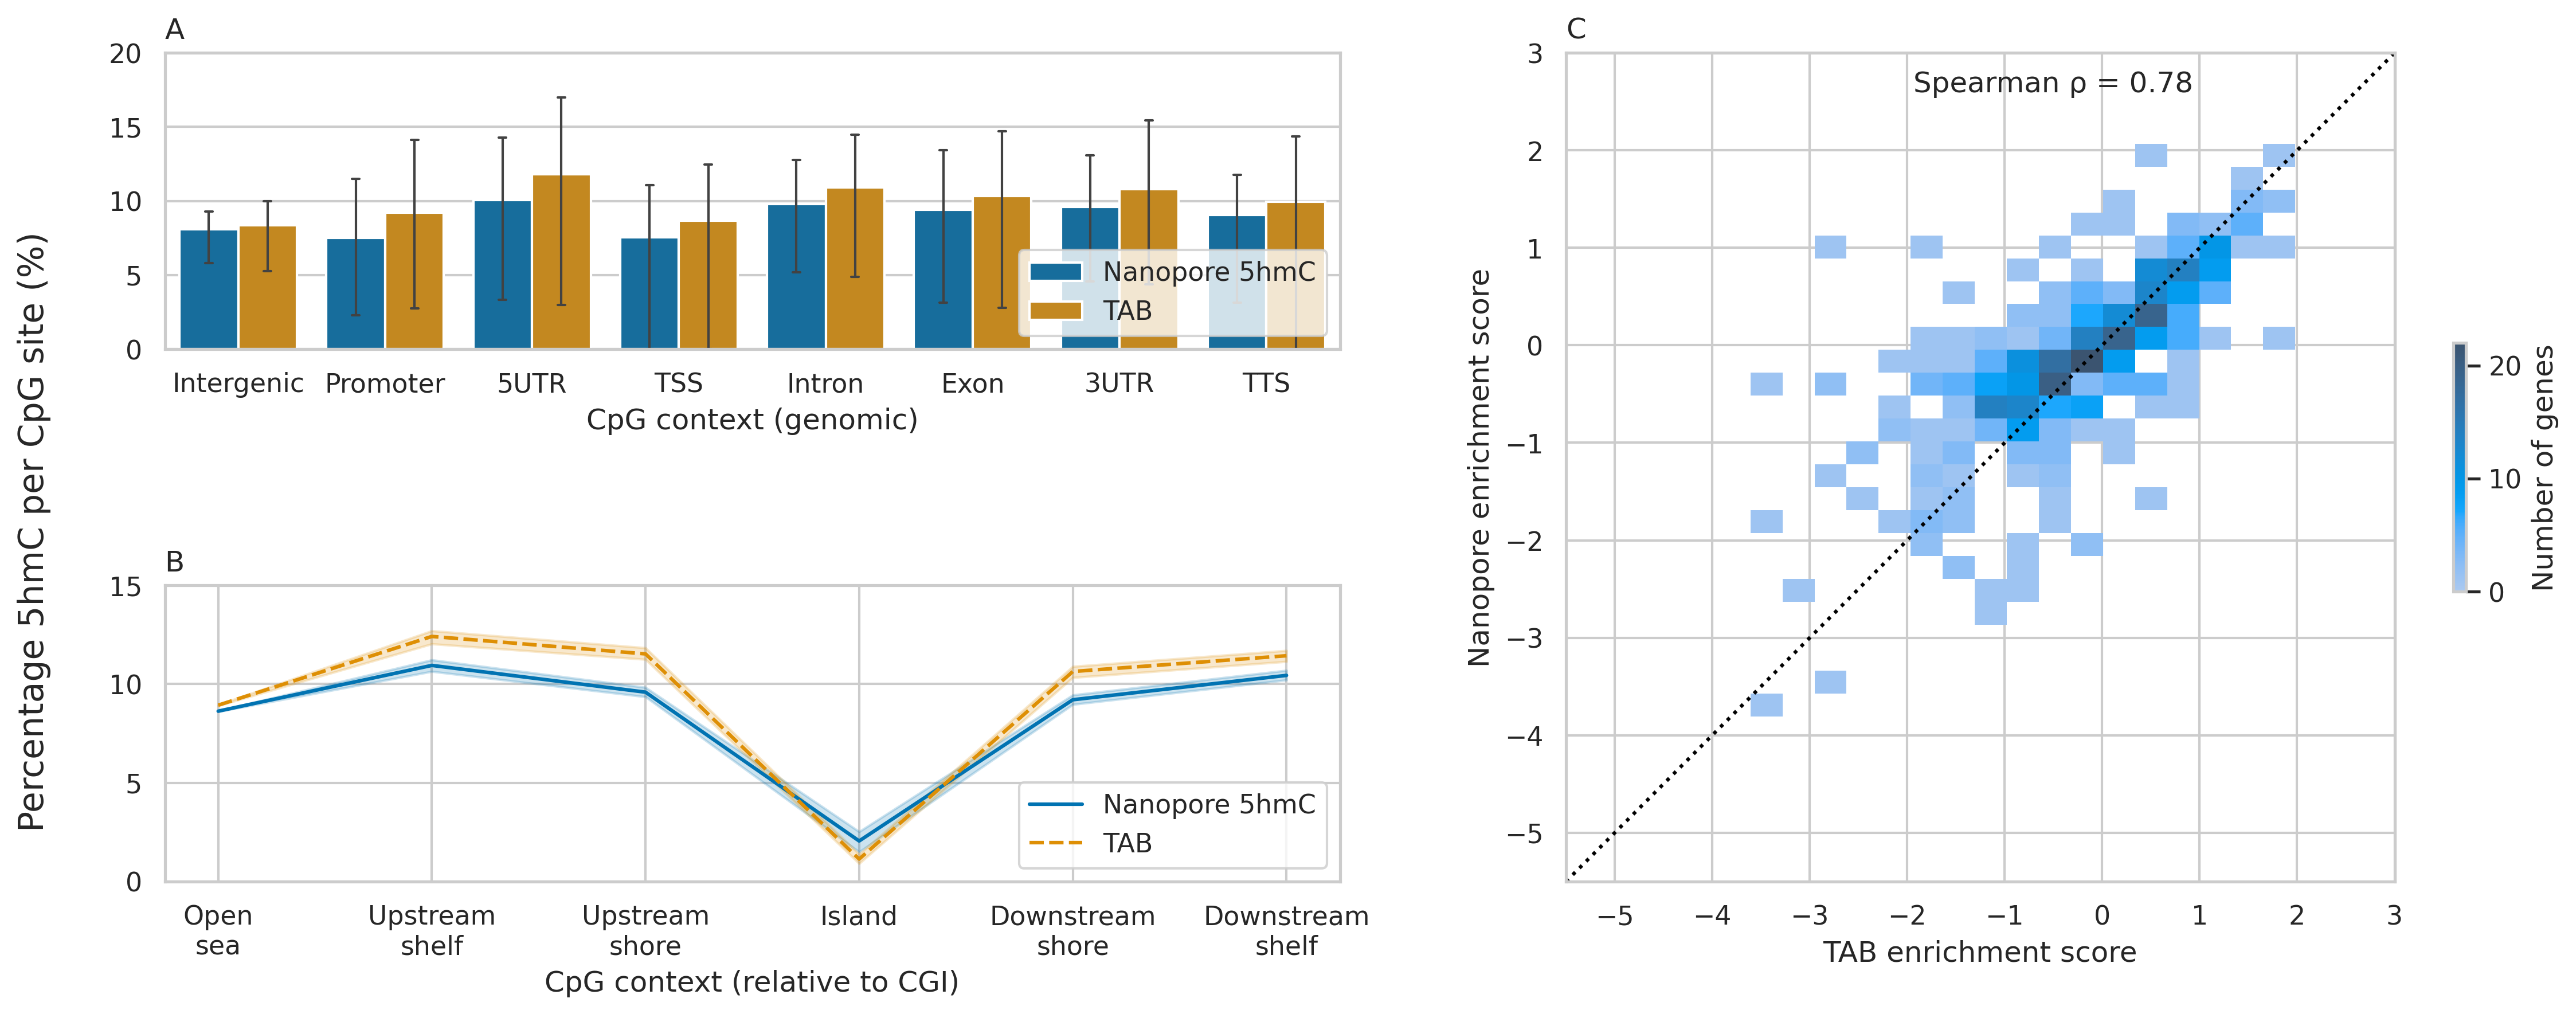

In [124]:
fig3 = plt.figure(dpi=300, figsize=(15, 7))
gs3 = GridSpec(1, 2, fig3)

fig32 = fig3.add_subfigure(gs3[:, 0])
fig32.supylabel("Percentage 5hmC per CpG site (%)", x=-0.07)
gs32 = GridSpec(2, 1, fig32)

ax32 = fig32.add_subplot(gs32[0, :])

sns.barplot(featureBarplot_df, x="feature_type", y="percentMeth", hue="method", capsize=0.05, errorbar=("pi", 50), errwidth=1, ax=ax32)
ax32.set_xlabel("CpG context (genomic)")
ax32.set_ylabel(None)
ax32.set_ylim((0, 20))
ax32.set_title("A", loc="left")
sns.move_legend(ax32, "lower right", title=None)

ax33 = fig32.add_subplot(gs32[1, :])

sns.lineplot(cgiLinePlot_df, x="feature_type", y="percentMeth", hue="method", style="method", errorbar=("ci", 50), err_style="band", ax=ax33)
ax33.set_xlabel("CpG context (relative to CGI)")
ax33.set_ylabel(None)
ax33.set_ylim((0, 15))
ax33.set_title("B", loc="left")
# ax33.tick_params("x", rotation=10, zorder=10)
ax33.set_xticklabels(["Open\nsea", "Upstream\nshelf", "Upstream\nshore", 
                      "Island", "Downstream\nshore", "Downstream\nshelf"])
sns.move_legend(ax33, "lower right", title=None)

fig31 = fig3.add_subfigure(gs3[0, 1])
ax31 = fig31.add_subplot()

sns.histplot(gene_log2_mean_df, x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", cbar=True, stat="count",
             cbar_kws={"label" : "Number of genes", 
                       "format" : "%d",
                       "shrink" : 0.3},
                       ax=ax31
             )
ax31.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")

ax31.set_aspect(1)
ax31.set_ylim((-5.5, 3))
ax31.set_xlim((-5.5, 3))
ax31.set_xlabel("TAB enrichment score")
ax31.set_ylabel("Nanopore enrichment score")
ax31.set_title("C", loc="left")

gene_rho, gene_p = stats.spearmanr(gene_log2_mean_df["Log2FromMean_Nanopore"], gene_log2_mean_df["Log2FromMean_Bisulphite"])
ax31.text(-0.5, 2.6, "Spearman \u03C1 = {rho:.2f}".format(rho=gene_rho), ha="center")


fig3.tight_layout(pad=4)

# PowerPoint style figures

These figures have been modified for standard PowerPoint dimensions to be used in presentations.

In [78]:
tile_df = tileMain() 
tile_df = tile_df.loc[tile_df["Count"] >= 10] 

/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


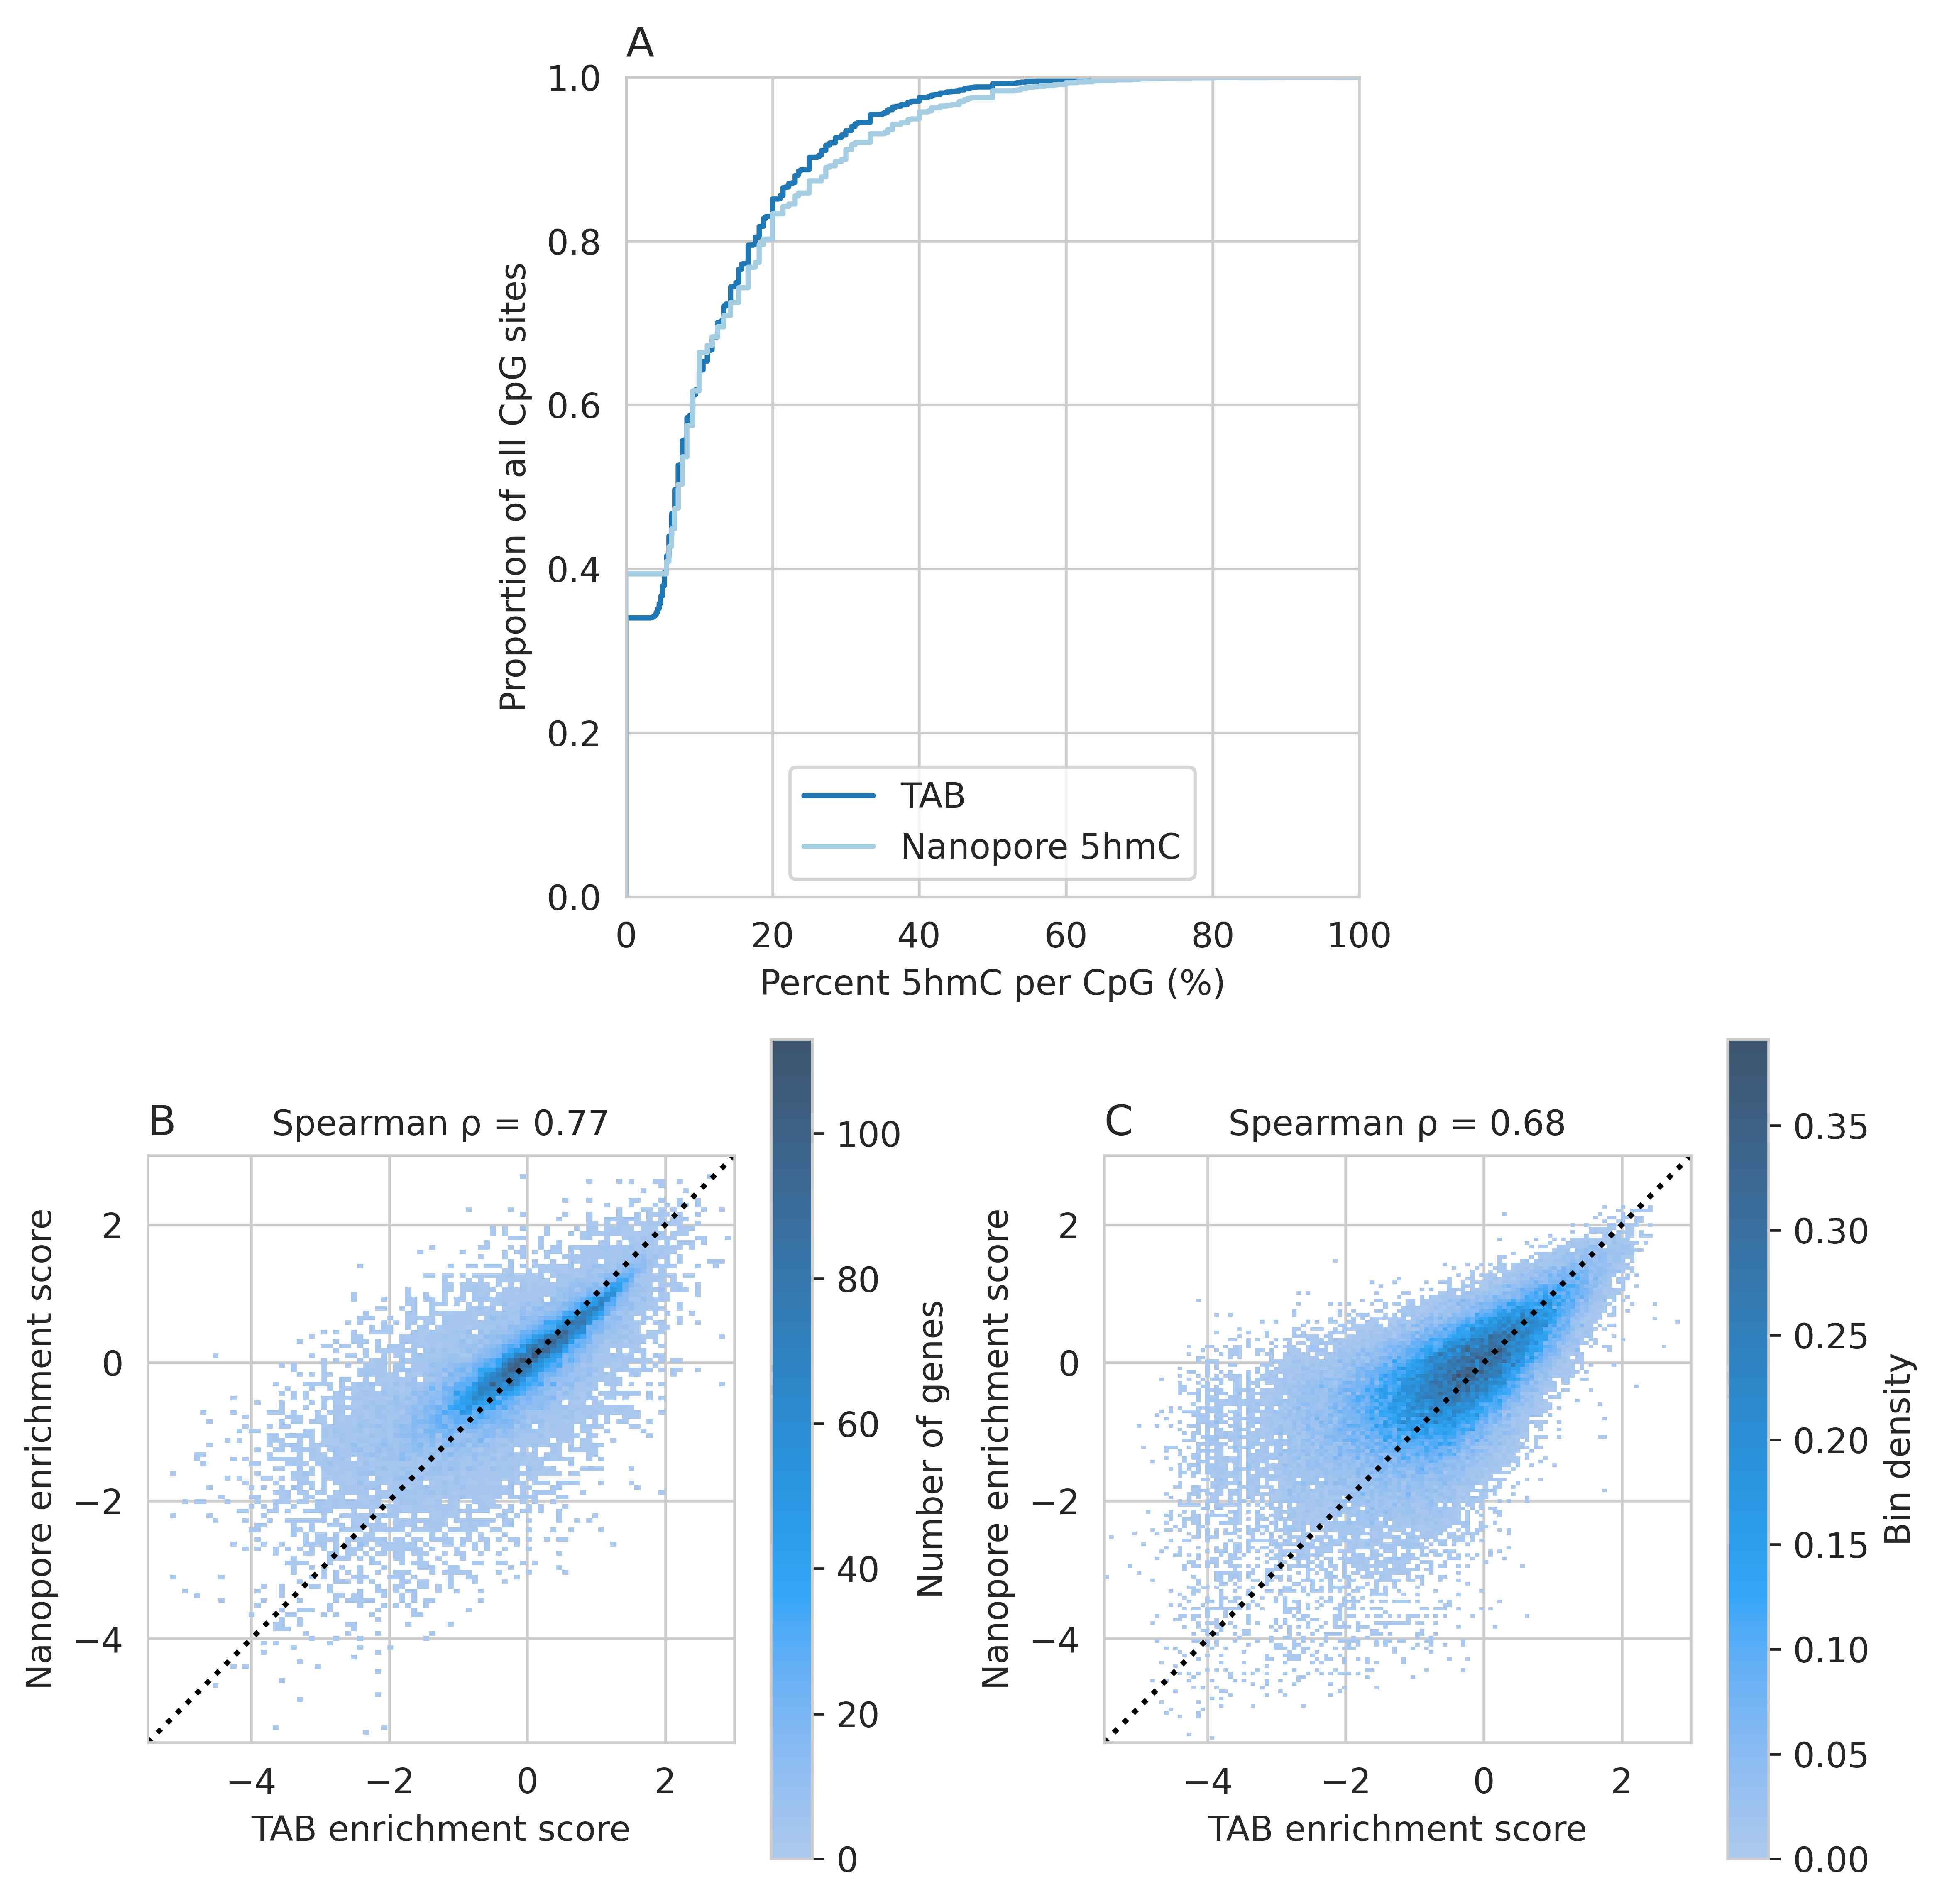

In [82]:
sns.set_style("whitegrid")

fig1 = plt.figure(figsize=((20)/2.54, (20)/2.54), dpi=600, facecolor="None")
gs = GridSpec(2, 4, fig1)

ax1 = fig1.add_subplot(gs[0, 1:3])
sns.ecdfplot(hmc_df_long, x="percentMeth", hue="method", palette="Paired", ax=ax1)
sns.move_legend(ax1, "lower center", title=None, labels=["TAB", "Nanopore 5hmC"])
ax1.set_ylabel("Proportion of all CpG sites")
ax1.set_xlabel("Percent 5hmC per CpG (%)")
ax1.set_xlim([0, 100])
ax1.set_title("A", loc="left")

ax2 = fig.add_subplot(gs[1, :2])
ax2.set_aspect("equal", adjustable="box")

sns.histplot(gene_log2_mean_df, x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", cbar=True, stat="count",
             cbar_kws={"label" : "Number of genes", 
                       "format" : "%d"},
                       ax=ax2)
ax2.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")
ax2.set_ylim((-5.5, 3))
ax2.set_xlim((-5.5, 3))

gene_rho, gene_p = stats.spearmanr(gene_log2_mean_df["Log2FromMean_Nanopore"], gene_log2_mean_df["Log2FromMean_Bisulphite"])
ax2.text(3-(5.5+3)/2, 3.3, "Spearman \u03C1 = {rho:.2f}".format(rho=gene_rho), ha="center")

ax2.set_xlabel("TAB enrichment score")
ax2.set_ylabel("Nanopore enrichment score")
ax2.set_title("B", loc="left")

ax3 = fig.add_subplot(gs[1, 2:])
ax3.set_aspect("equal", adjustable="box")

sns.histplot(tile_df, x="Log2FromMean_Bisulphite", y="Log2FromMean_Nanopore", cbar=True, stat="density",
            cbar_kws={"label" : "Bin density"},
            ax=ax3)

tile_rho, tile_p = stats.spearmanr(tile_df["Log2FromMean_Nanopore"], tile_df["Log2FromMean_Bisulphite"])

ax3.text(3-(5.5+3)/2, 3.3, "Spearman \u03C1 = {rho:.2f}".format(rho=tile_rho), ha="center")
ax3.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")
ax3.set_title("C", loc="left")
ax3.set_ylim((-5.5, 3))
ax3.set_xlim((-5.5, 3))
ax3.set_xlabel("TAB enrichment score")
ax3.set_ylabel("Nanopore enrichment score")

fig.tight_layout()

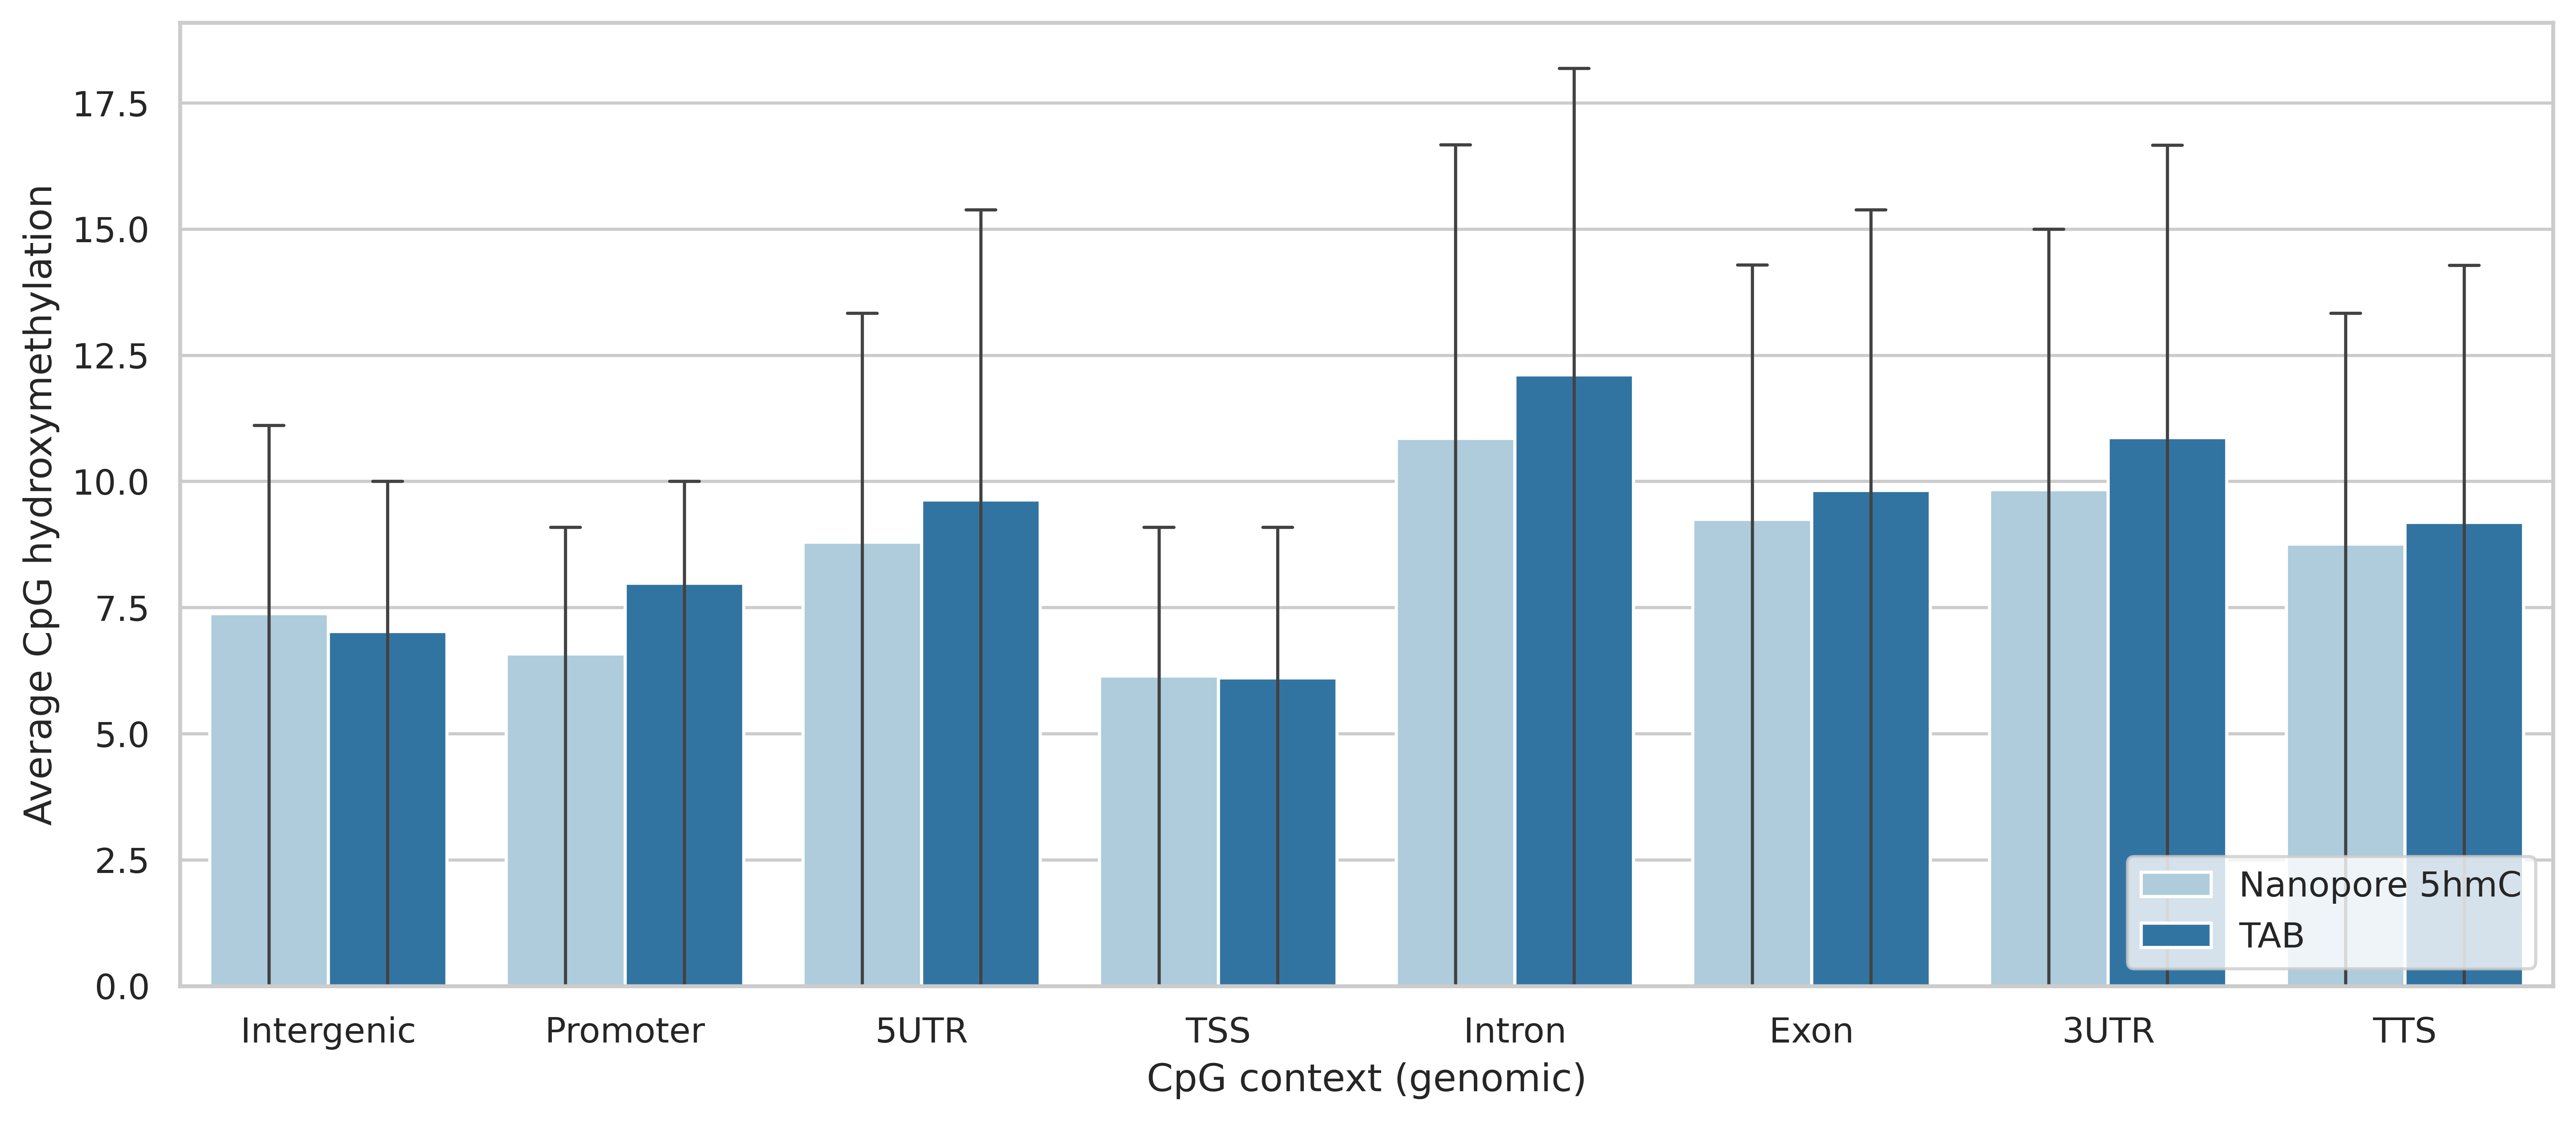

In [142]:
fig = plt.figure(figsize=((29.1)/2.54, (12.9)/2.54), dpi=600, facecolor="None")
gs = GridSpec(1, 1, fig)
sns.set_style("whitegrid")
sns.set_palette("Paired")

ax32 = fig.add_subplot(gs[0, :])

sns.barplot(featureBarplot_df, x="feature_type", y="percentMeth", hue="method", errorbar=("pi", 50), capsize=0.1, errwidth=1, ax=ax32)
ax32.set_xlabel("CpG context (genomic)")
ax32.set_ylabel("Average CpG hydroxymethylation")
# ax32.set_ylim((0, 40))
sns.move_legend(ax32, "lower right", title=None)    

fig.tight_layout()

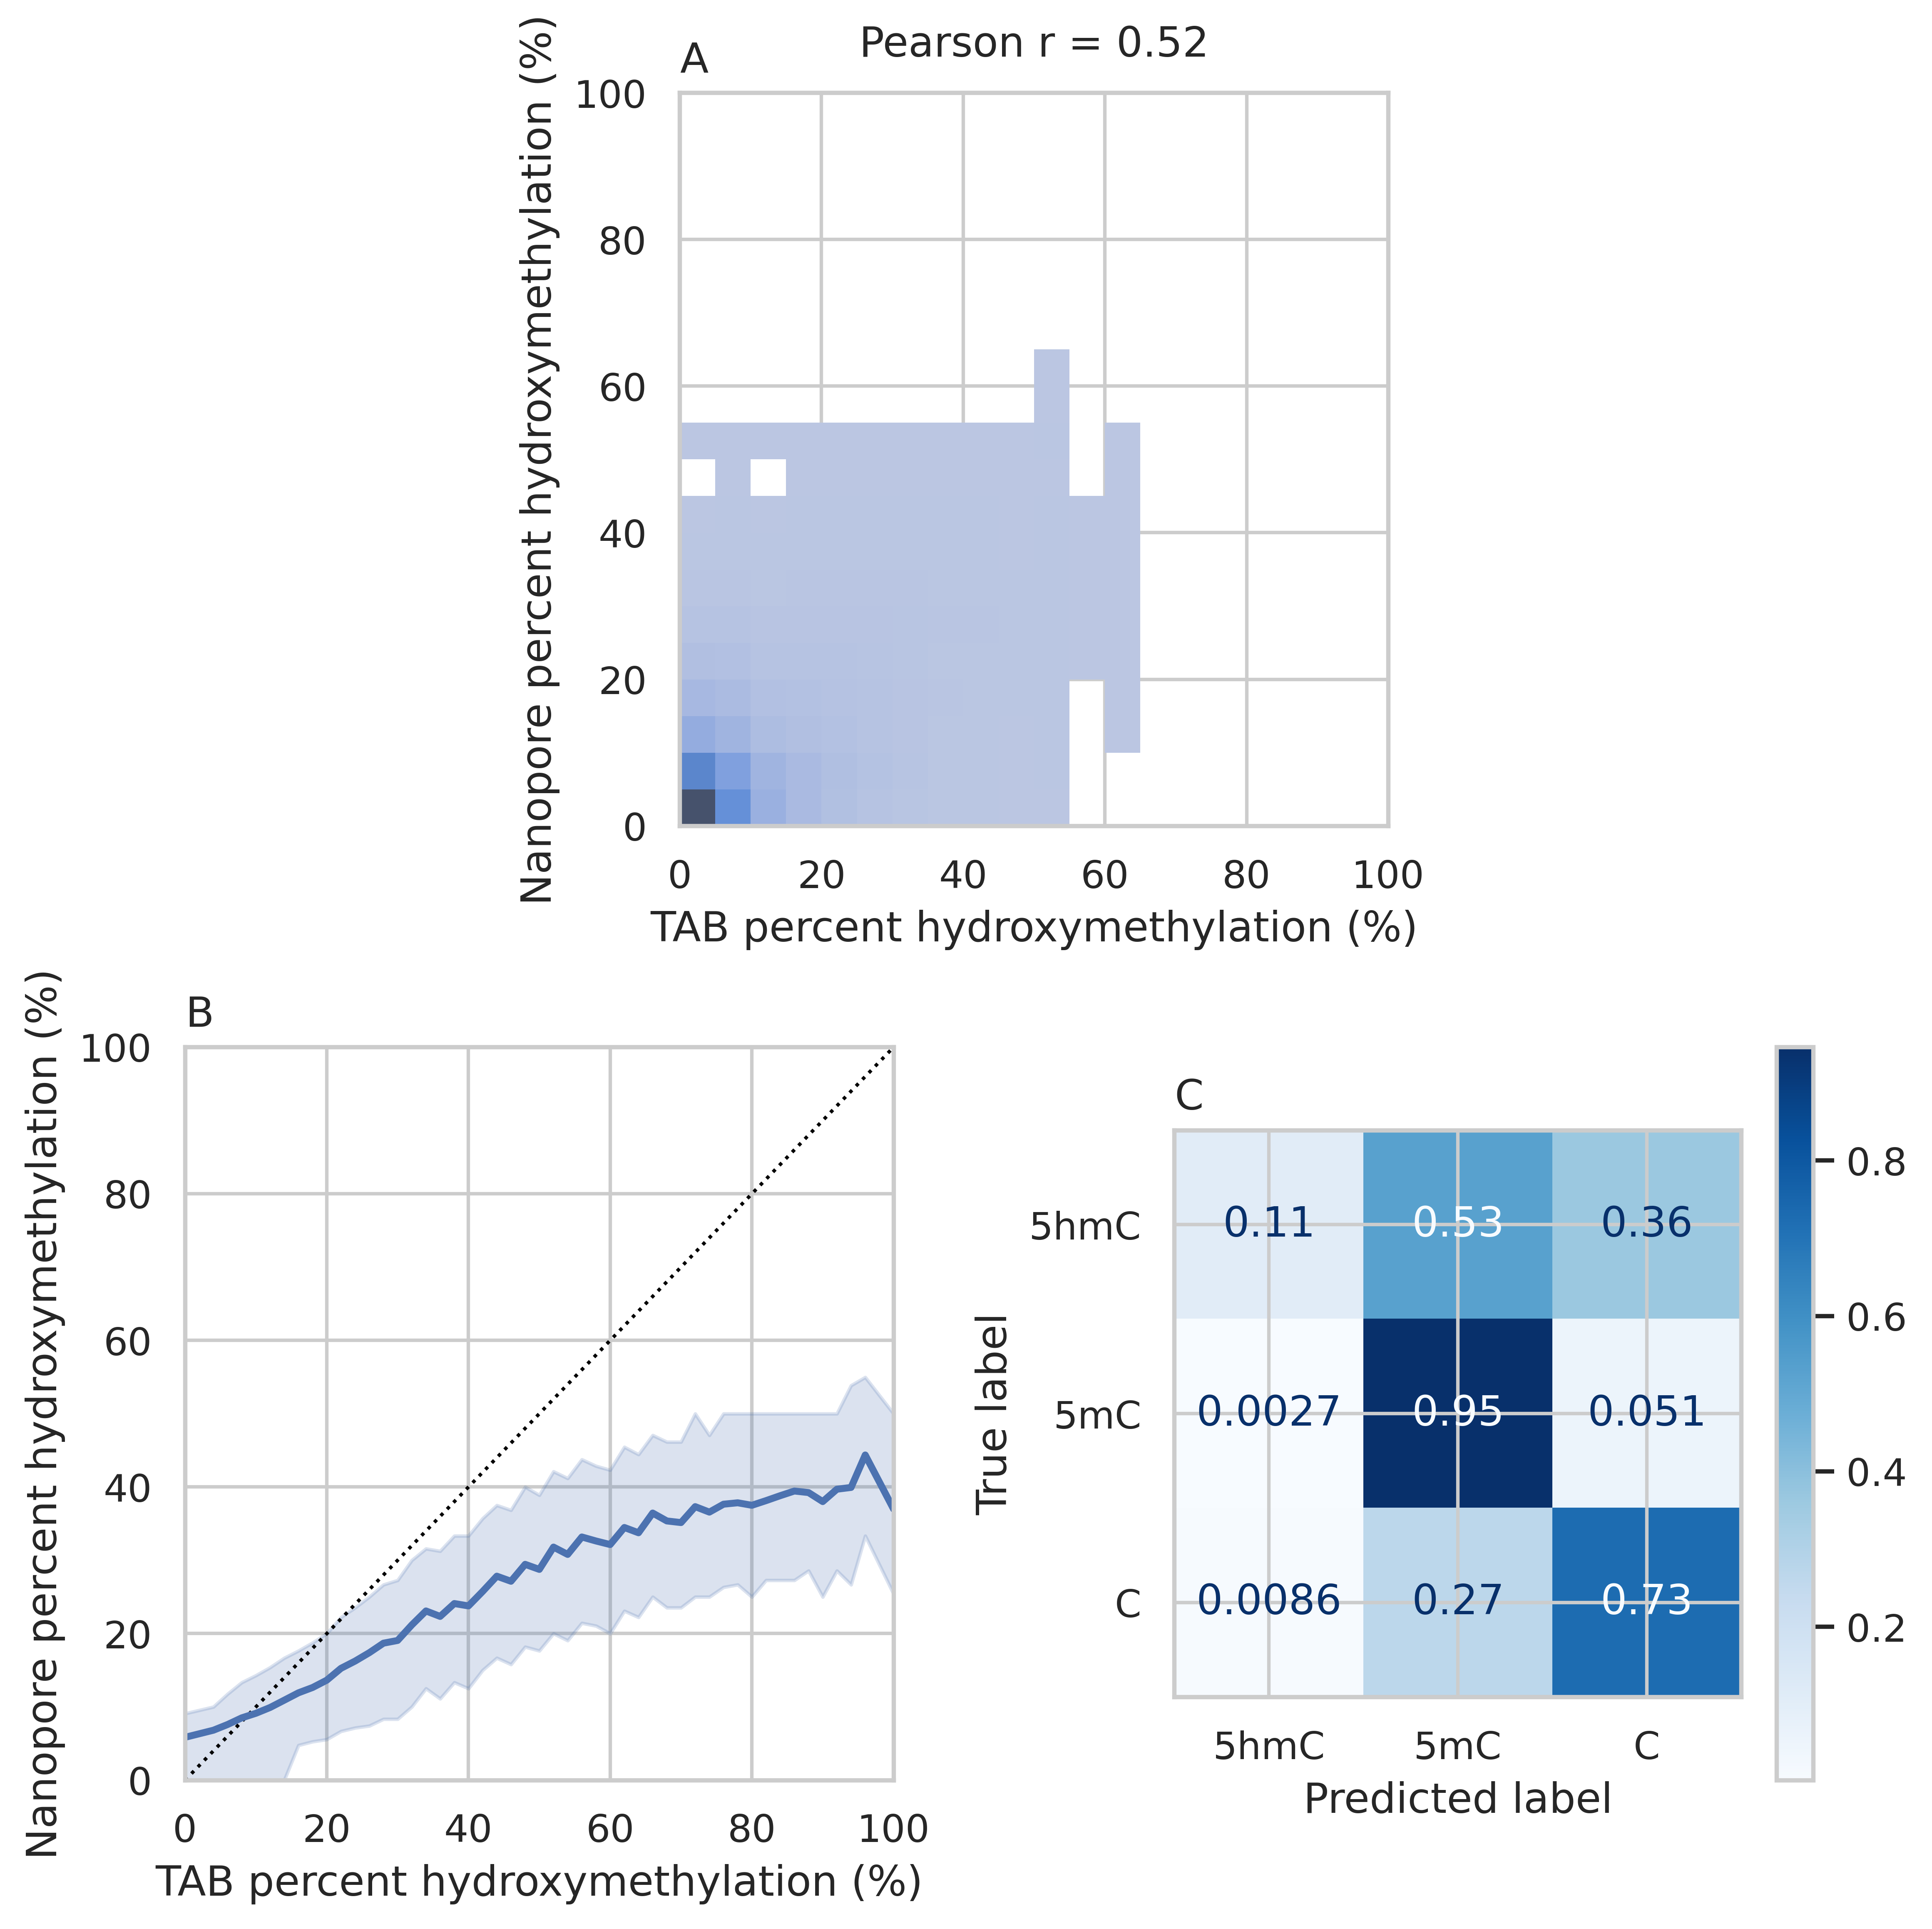

In [130]:
sns.set_style("whitegrid")

fig = plt.figure(figsize=((20)/2.54, (20)/2.54), dpi=600, facecolor="None")
gs = GridSpec(2, 4, fig)

ax1 = fig.add_subplot(gs[0, 1:3])
sns.histplot(hmc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax1)
ax1.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(hmc_df_wide)[0]), ha="center")
ax1.set_xlim((0, 100))
ax1.set_ylim((0, 100))
ax1.set_ylabel("Nanopore percent hydroxymethylation (%)")
ax1.set_xlabel("TAB percent hydroxymethylation (%)")
ax1.set_title("A", loc="left")

ax2 = fig.add_subplot(gs[1, :2])
ax2.plot(np.arange(0, 105, 5), np.arange(0, 105, 5), linestyle=":", lw=1, color="black")
sns.lineplot(binBenchmark(hmc_df_wide), x="bin", y="percentMeth_Nanopore", errorbar=("pi", 50), err_style="band", linewidth=2, ax=ax2)
ax2.set_ylim((0, 100))
ax2.set_xlim((0, 100))
ax2.set_xlabel("TAB percent hydroxymethylation (%)")
ax2.set_ylabel("Nanopore percent hydroxymethylation (%)")
ax2.set_title("B", loc="left")

ax3 = fig.add_subplot(gs[1, 2:])
ConfusionMatrixDisplay.from_predictions(defineTruthset(), definePredictions(), normalize="true", cmap="Blues", ax=ax3)
ax3.set_title("C", loc="left")

fig.tight_layout()

In [6]:
import pyBigWig # required for bigWig output of pr 

def makeChromSizes():
    init = pd.read_csv('./feature_references/revised/mm39.chrom.sizes', sep="\t", names=["Chromosome", "End", "Start"])
    init["Start"] = 0
    init = init[["Chromosome", "Start", "End"]]
    return pr.PyRanges(init).sort()

In [ ]:
# three_mod_pr.to_bigwig('./outputs/nanopore_5hmC_chr1.bw', chromosome_sizes=makeChromSizes(), value_col="percentMeth_Nanopore_5hmC")

# Read level information at imprinted and non-imprinted sites

These scripts extract read level information from the modified bam files and perform clustering based on CpG site methylation states. The resulting clustermaps help to clearly show CpG sites with similar modification status. 

Of note, CpG sites are here aggregated (merged + and - strands) for ease of visualisation. 

In [2]:
from modbampy import ModBam
import pandas as pd
import pyranges as pr
import numpy as np

In [92]:
grb10_pr = pr.PyRanges(chromosomes="chr11", starts=[11878499], ends=[11989420], int64=True) # grb10 used here as an example (start/end coordinates based on mm39)
tiled_grb10_df = grb10_pr.tile(3000).as_df()
tiled_grb10_dict = tiled_grb10_df.to_dict("index")

In [117]:
with ModBam('./data/prom_R10.4.1_E8.2_WGS_brain_DH_grb10.bam') as bam:
    tile_list = []
    tile_id = 1
    for tile in tiled_grb10_dict.values():
        read_list = []
        for read in bam.reads(tile["Chromosome"], tile["Start"], tile["End"]):
            read_sites = []
            for mod_position in read.mod_sites:
                mod_position_info = [tile_id, tile["Chromosome"], tile["Start"], tile["End"]]
                for datum in mod_position:
                    mod_position_info.append(datum)
                read_sites.append(mod_position_info)
            read_list.extend(read_sites)
        tile_list.extend(read_list)
        tile_id += 1 
names=["tile", "chromosome", "chromStart", "chromEnd", "read", "refPos", "qPos", "refStrand", "modStrand", "base", "mod", "score"]
tile_df = pd.DataFrame(tile_list, columns=names)
    
def filterTile(tile): 
    # tile_df.loc[tile_df["refStrand"] == "-", "refPos"] = tile_df["refPos"].sub(2, axis=0)
    one_tile_df = tile_df.loc[(tile_df["tile"] == tile) & (tile_df["refPos"].ge(tile_df["chromStart"])) & (tile_df["refPos"].lt(tile_df["chromEnd"]))] 
    
    tile_df_pivot1 = one_tile_df.pivot(index=["tile", "chromosome", "chromStart", "chromEnd", "refStrand", "read", "refPos", "qPos"], columns="mod", values="score").reset_index()
    tile_df_pivot1["c"] = 255 - tile_df_pivot1[["h", "m"]].sum(axis=1)
    tile_df_melt = pd.melt(tile_df_pivot1, ["tile", "chromosome", "chromStart", "chromEnd", "refStrand", "read", "refPos", "qPos"], ["h", "m", "c"], "mod", "score")
    tile_df_melt = tile_df_melt.loc[tile_df_melt["score"] >= 0.66*255]
    tile_df_melt.loc[tile_df_melt["refStrand"] == "-", "refPos"] = tile_df_melt["refPos"].sub(1, axis=0)

    return tile_df_melt.reset_index(drop=True)

def pivotToHeatmap(df):
    df = df.pivot(index="read", columns=["refPos"], values="mod")
    df[df == "c"] = 0
    df[df == "h"] = 2
    df[df == "m"] = 1
    
    return df

def NADropper(df):
    new_df = df.dropna(thresh=len(df)*0.2, axis="columns") # removes CpGs present in fewer than 20% of reads
    new_df = new_df.dropna(thresh=len(new_df.columns)*0.50, axis="index") # removes reads with fewer than x% of CpGs
    return new_df

def makeHeatmap(tile):

    data = NADropper(pivotToHeatmap(filterTile(tile)))

    fig = sns.clustermap(data.fillna(-1), 
                mask=data.isna(), 
                xticklabels=10, yticklabels=False,
                col_cluster=False, row_cluster=True, 
                cmap=sns.color_palette("Blues", 3),
                cbar_kws={"ticks" : [0, 1, 2],
                        "orientation" : "horizontal"},
                figsize=(10, 10))

    fig.ax_cbar.set_position([0.40, 0.85, 0.3, 0.03])
    fig.ax_cbar.set_xticks([0.33, 1, 1.66])
    fig.ax_cbar.set_xticklabels(["C", "5mC", "5hmC"])
    fig.ax_cbar.set_title("Modification type", fontdict={"fontsize" : 10})
    fig.ax_heatmap.set_ylabel("Read")
    fig.ax_heatmap.set_xlabel("CpG position")

    return fig

In [6]:
import numpy as np

def makeTileHeatmaps():
    for tile in np.arange(1, 39, 1):
        fig = makeHeatmap(tile)
        fig.savefig(f'./outputs/Grb10_heatmaps/tile_{tile}_heatmap.png', dpi=600)
        plt.close(fig)
    return 

makeTileHeatmaps()

NameError: name 'makeHeatmap' is not defined

# Final Figures

## Imports

In [29]:
import pandas as pd
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import subprocess

## Figure 1

In [28]:
##### Fig1 #####

sns.set_style("whitegrid")

fig1 = plt.figure(figsize=((30)/2.54, (20)/2.54), dpi=600, facecolor="None")
gs1 = GridSpec(2, 6, fig1)

##### ax100 ##### 

ax100 = fig1.add_subplot(gs1[0, :2])

two_mod_wide = Checkpoint(path="./intermediates/two_mod_wide.tsv").loadCheckpoint()

sns.histplot(two_mod_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax100)
ax100.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(two_mod_wide)[0]), ha="center")
ax100.set_xlim((0, 100))
ax100.set_ylim((0, 100))
ax100.set_xlabel("WGBS modification per CpG (%)")
ax100.set_ylabel("Nanopore modification per CpG (%)")
ax100.set_title("A", loc="left")

##### ax101 ##### 

ax101 = fig1.add_subplot(gs1[0, 2:4])

mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()

sns.histplot(mc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax101)
ax101.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(mc_df_wide)[0]), ha="center")
ax101.set_xlim((0, 100))
ax101.set_ylim((0, 100))
ax101.set_xlabel("oxBS 5mC per CpG (%)")
ax101.set_ylabel("Nanopore 5mC per CpG (%)")
ax101.set_title("B", loc="left")

##### ax102 ##### 

ax102 = fig1.add_subplot(gs1[0, 4:])

hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

sns.histplot(hmc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax102)
ax102.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(hmc_df_wide)[0]), ha="center")
ax102.set_xlim((0, 100))
ax102.set_ylim((0, 100))
ax102.set_xlabel("TAB 5hmC per CpG (%)")
ax102.set_ylabel("Nanopore 5hmC per CpG (%)")
ax102.set_title("C", loc="left")

##### ax110 ##### 

ax110 = fig1.add_subplot(gs1[1, 1:3])
ax110.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), "black", linestyle=":")

ROCPlot(two_mod_wide).plotROC(ax110, "vs. WGBS; AUC={AUC:.3f}".format(AUC=ROCPlot(two_mod_wide).calculateAUC()))
ROCPlot(mc_df_wide).plotROC(ax110, "vs. oxBS; AUC={AUC:.3f}".format(AUC=ROCPlot(mc_df_wide).calculateAUC()))
ROCPlot(hmc_df_wide).plotROC(ax110, "vs. TAB; AUC={AUC:.3f}".format(AUC=ROCPlot(hmc_df_wide).calculateAUC()))

ax110.set_xlabel("False positive rate")
ax110.set_ylabel("True positive rate")
ax110.legend()
sns.move_legend(ax110, "lower right")
ax110.set_title("D", loc="left")

##### ax111 ##### 

ax111 = fig1.add_subplot(gs1[1, 3:5])
ConfusionMatrixDisplay.from_predictions(defineTruthset(), definePredictions(), normalize="true", cmap="Blues", ax=ax111)
ax111.set_xlabel("Nanopore label")
ax111.set_ylabel("Bisulphite label")
ax111.set_title("E", loc="left")

fig1.set_tight_layout(True)
fig1.savefig('/u/n/doh28/Documents/Nanopore_HMC/Figures/Figure1.png')
fig1.show()

NameError: name 'GridSpec' is not defined

<Figure size 7086.61x4724.41 with 0 Axes>

In [22]:
print(ROCPlot(two_mod_wide).calculateAUC(), ROCPlot(mc_df_wide).calculateAUC(), ROCPlot(hmc_df_wide).calculateAUC())

0.9851352896715706 0.9381564048249582 0.89450212170618


## Figure 2

/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


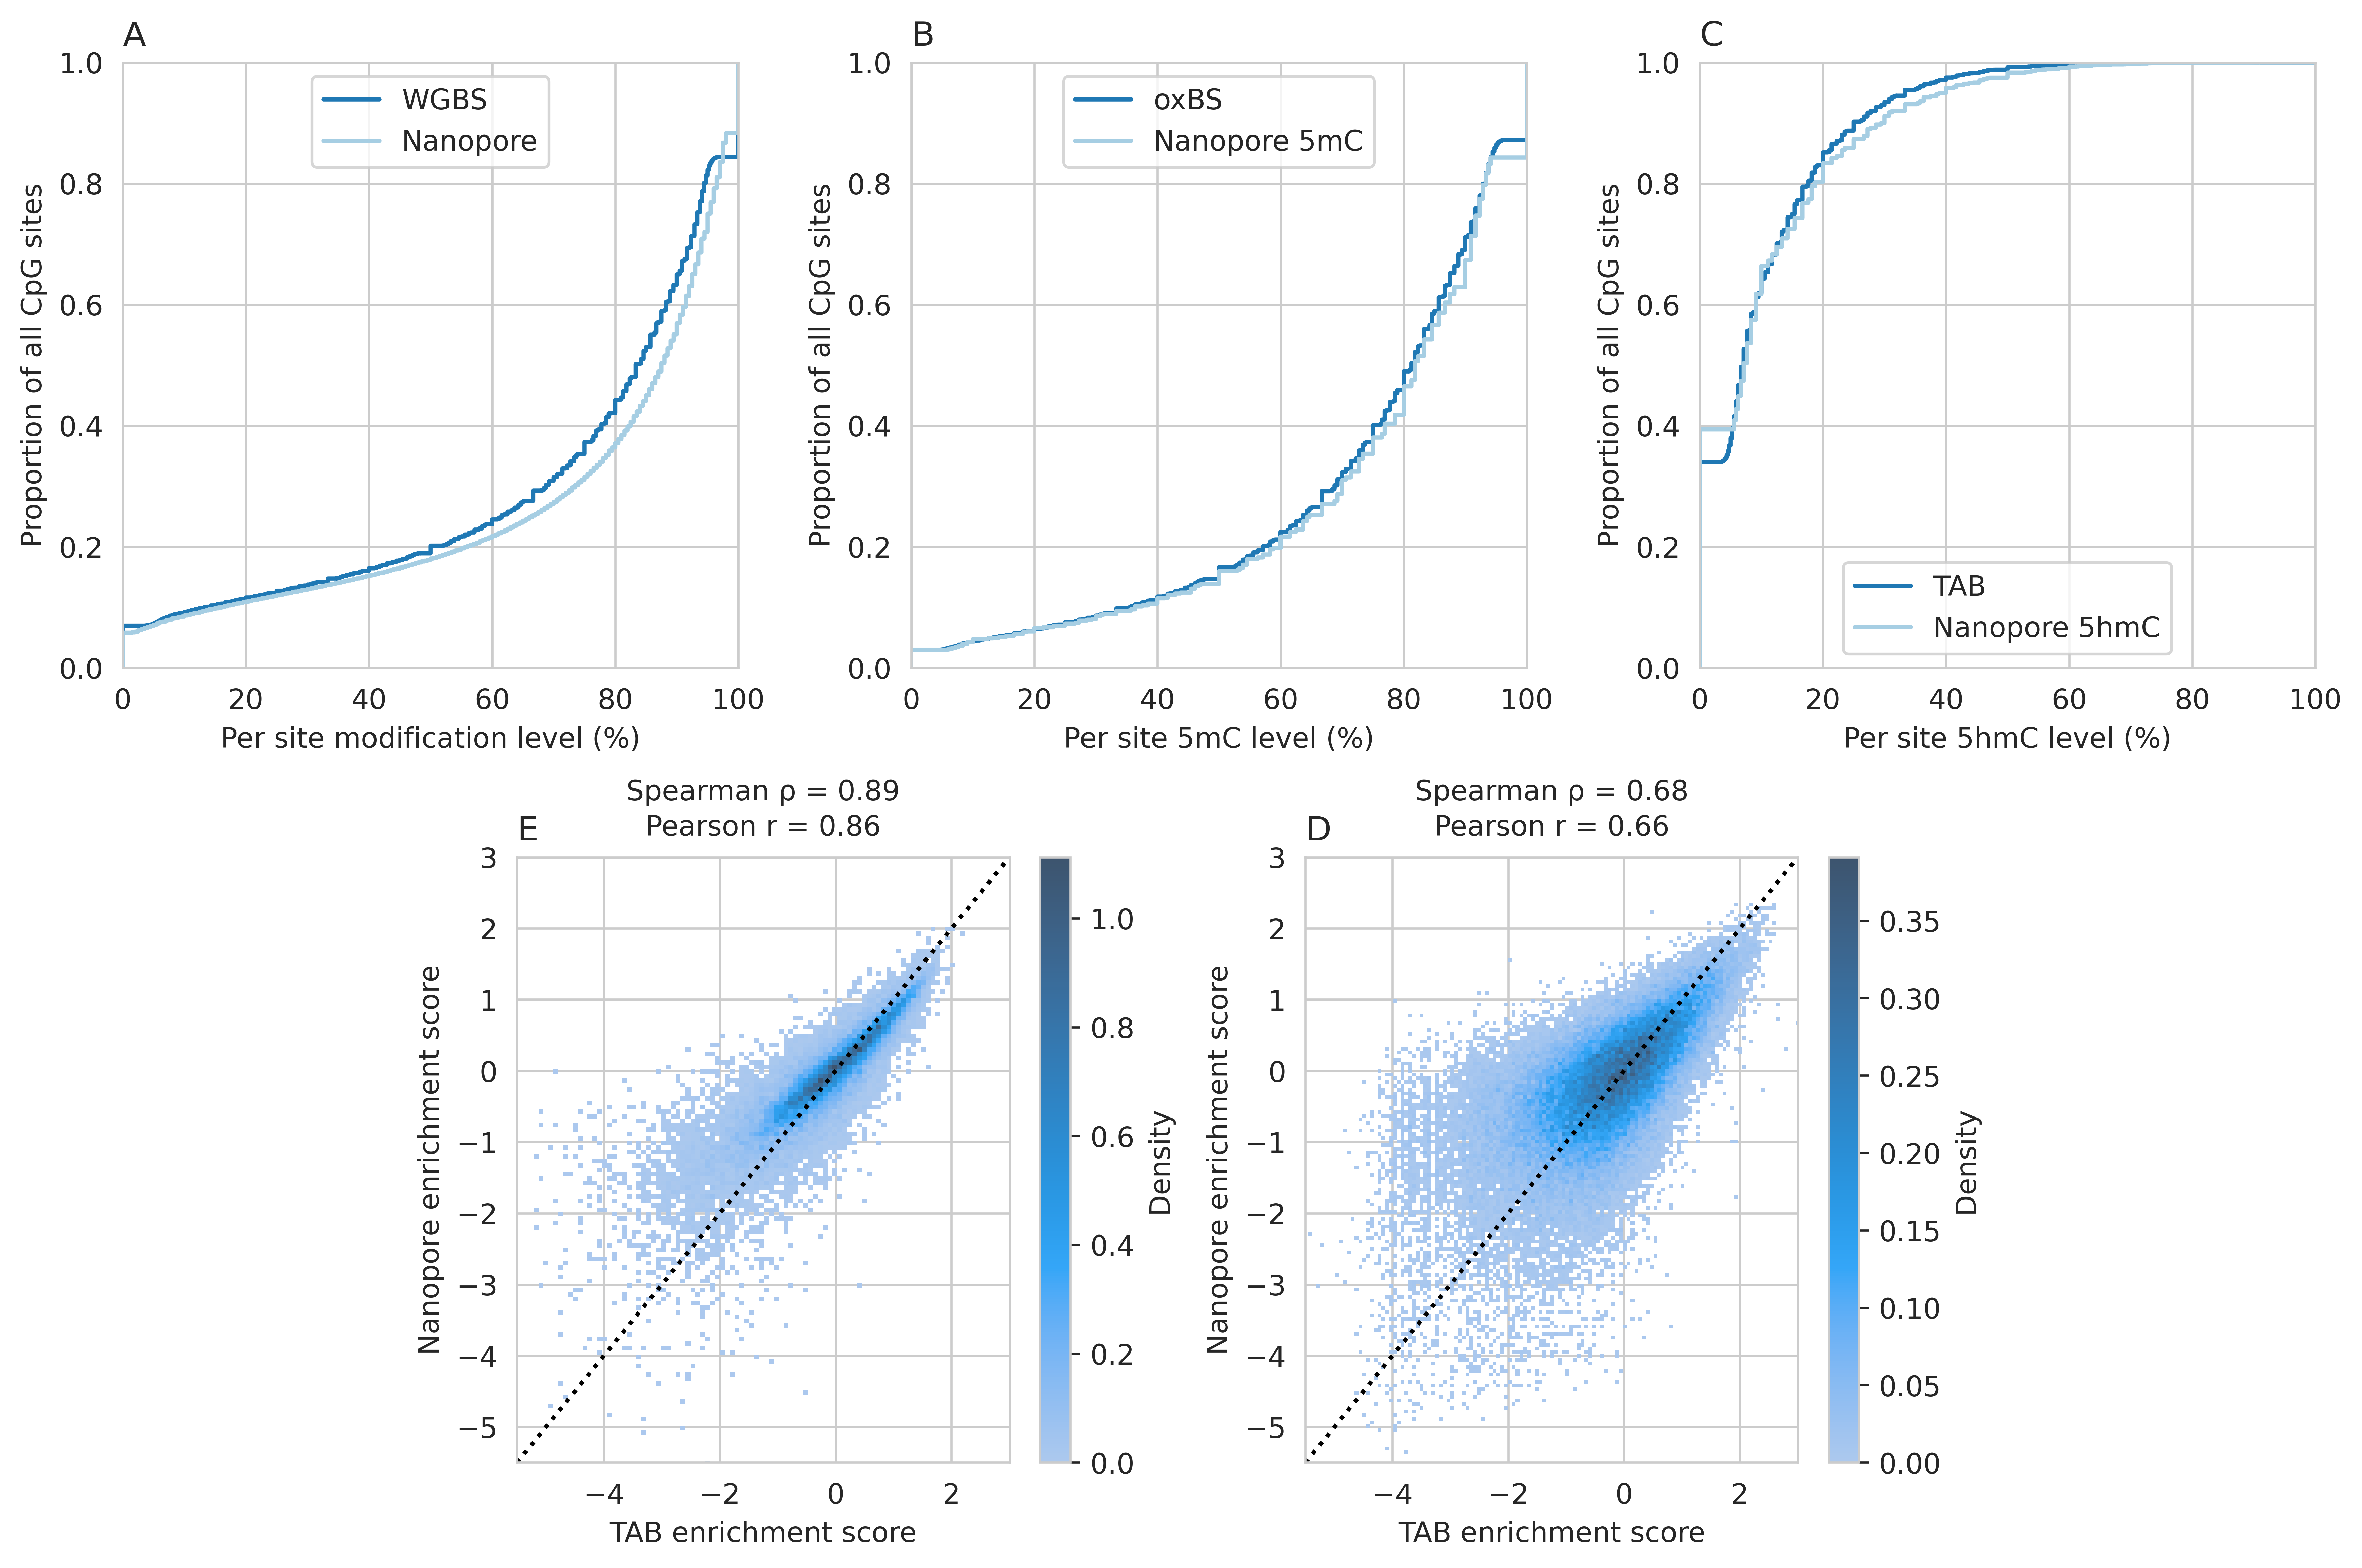

In [20]:
##### Fig2 #####

sns.set_style("whitegrid")

fig2 = plt.figure(figsize=((30)/2.54, (20)/2.54), dpi=600, facecolor="None")
gs2 = GridSpec(2, 6, fig2)

##### ax100 ##### 

ax200 = fig2.add_subplot(gs2[0, :2])

sns.ecdfplot(Checkpoint(path='./intermediates/two_mod_long.tsv').loadCheckpoint(), 
             x="percentMeth", hue="method", legend=True, palette="Paired", ax=ax200)
sns.move_legend(ax200, "upper center", title=None, labels=["WGBS", "Nanopore"])
ax200.set_ylabel("Proportion of all CpG sites")
ax200.set_xlabel("Per site modification level (%)")
ax200.set_xlim([0, 100])
ax200.set_ylim([0, 1])
ax200.set_title("A", loc="left")

##### ax201 ##### 

ax201 = fig2.add_subplot(gs2[0, 2:4])

sns.ecdfplot(Checkpoint(path='./intermediates/mc_df_long.tsv').loadCheckpoint(), 
             x="percentMeth", hue="method", legend=True, palette="Paired", ax=ax201)
sns.move_legend(ax201, "upper center", title=None, labels=["oxBS", "Nanopore 5mC"])
ax201.set_ylabel("Proportion of all CpG sites")
ax201.set_xlabel("Per site 5mC level (%)")
ax201.set_xlim([0, 100])
ax201.set_ylim([0, 1])
ax201.set_title("B", loc="left")

##### ax202 ##### 

ax202 = fig2.add_subplot(gs2[0, 4:])

sns.ecdfplot(Checkpoint(path='./intermediates/hmc_df_long.tsv').loadCheckpoint(), 
             x="percentMeth", hue="method", legend=True, palette="Paired", ax=ax202)
sns.move_legend(ax202, "lower center", title=None, labels=["TAB", "Nanopore 5hmC"])
ax202.set_ylabel("Proportion of all CpG sites")
ax202.set_xlabel("Per site 5hmC level (%)")
ax202.set_xlim([0, 100])
ax202.set_ylim([0, 1])
ax202.set_title("C", loc="left")

##### Histogram shared #####

data = Checkpoint(path='./intermediates/three_mod_pyrange.tsv').loadCheckpoint()

##### ax220 ##### 

ax220 = fig2.add_subplot(gs2[1, 3:5])

tile_data = tiledGroup(CpGIntersects(data).groupByGenomicWindow(300), 5)

tile_data.makeHist("count", ax=ax220)
ax220.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")

tile_r, tile_p = tile_data.calcPearson()
tile_rho, tile_p = tile_data.calcSpearman()

ax220.text(3-(5.5+3)/2, 3.3, "Pearson r = {r:.2f}".format(r=tile_r), ha="center")
ax220.text(3-(5.5+3)/2, 3.8, "Spearman \u03C1 = {rho:.2f}".format(rho=tile_rho), ha="center")
ax220.set_ylim((-5.5, 3))
ax220.set_xlim((-5.5, 3))
ax220.set_xlabel("TAB enrichment score")
ax220.set_ylabel("Nanopore enrichment score")
ax220.set_title("D", loc="left")

##### ax220 #####

ax221 = fig2.add_subplot(gs2[1, 1:3])

gene_data = featureAndGene(CpGIntersects(data).group("genes"))

gene_data.makeHist("density", ax221)
ax221.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")

gene_r, gene_p = gene_data.calcPearson()
gene_rho, gene_rhoP = gene_data.calcSpearman()

ax221.text(3-(5.5+3)/2, 3.3, "Pearson r = {r:.2f}".format(r=gene_r), ha="center")
ax221.text(3-(5.5+3)/2, 3.8, "Spearman \u03C1 = {rho:.2f}".format(rho=gene_rho), ha="center")
ax221.set_ylim((-5.5, 3))
ax221.set_xlim((-5.5, 3))
ax221.set_xlabel("TAB enrichment score")
ax221.set_ylabel("Nanopore enrichment score")
ax221.set_title("E", loc="left")

fig2.set_tight_layout(True)
fig2.savefig('/u/n/doh28/Documents/Nanopore_HMC/Figures/Figure2.png')
fig2.tight_layout()

### Figure 2 Data Table

In [8]:
data = Checkpoint(path='./intermediates/three_mod_pyrange.tsv').loadCheckpoint()

In [15]:
tiles = tiledGroup(CpGIntersects(data).groupByGenomicWindow(300), 5)

In [25]:
tiles.exportTestGroups()

AttributeError: 'tiledGroup' object has no attribute 'exportTestGroups'

In [ ]:
df.to_excel()